# 0.0. Imports

In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
import boruta as bt
import xgboost as xgb
import scikitplot as skplt
import pickle
import json

from matplotlib import pyplot as plt
from IPython.core.display  import HTML

from sklearn import preprocessing   as pp
from sklearn import model_selection as ms
from sklearn import ensemble        as en
from sklearn import linear_model    as lm
from sklearn import neighbors       as nh

import random
import warnings
warnings.filterwarnings('ignore')

# 0.1. Helper Functions

In [19]:
def precision_at_k( data, kperc=0.20 ):
    k = int(len(data) * kperc)
    data = data.reset_index( drop=True )
    data['ranking'] = data.index + 1
    
    data['precision_at_k'] = data['response'].cumsum() / data['ranking']
    
    return ( data.loc[ k, 'precision_at_k'], data )

def recall_at_k( data, kperc=0.20 ):
    k = int(len(data) * kperc)
    data = data.reset_index( drop=True )
    data['ranking'] = data.index + 1
    
    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()
    
    return ( data.loc[ k, 'recall_at_k'], data )


def cross_validation( x, y, kfold, model_name, model, kperc, verbose=False ):
    precision_at_k_list = []
    recall_at_k_list = []

        
    skfold = ms.StratifiedKFold(n_splits=5)

    fold = 1
    for train_index, val_index in skfold.split(x, y):
        #print(f" train index: {train_index}  val index: {val_index}")

        x_train_fold = x.iloc[train_index, :]
        x_val_fold = x.iloc[val_index, :]
        y_train_fold = y.iloc[train_index, :]
        y_val_fold = y.iloc[val_index, :]

        
        if verbose:
            print( '\nKFold Number: {}'.format( fold ) )
        # start and end date for validation

        
        # model
        m = model.fit( x_train_fold, y_train_fold )

        # prediction
        yhat = m.predict_proba( x_val_fold)

   
        df_aux = x_val_fold.copy()
        df_aux['response'] = y_val_fold.copy()
        
        # propensity score
        df_aux['score'] = yhat[:, 1].tolist()
        
        # sort clients by propensity score
        df_aux = df_aux.sort_values( 'score', ascending=False )

        
        # performance
        precisionk, data_precision = precision_at_k( df_aux, kperc )
        recallk, data_recall = recall_at_k(df_aux, kperc)
        
        # store performance of each kfold iteration
        precision_at_k_list.append( precisionk )
        recall_at_k_list.append( recallk )

        fold += 1
       
    return pd.DataFrame({'Model Name': model_name,
                         'Precision_at_k': np.round( np.mean( precision_at_k_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( precision_at_k_list ), 2 ).astype( str ),
                         'Recall_at_k': np.round( np.mean( recall_at_k_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( recall_at_k_list ), 2 ).astype( str )}, index=[0])




def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [20]:
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


# 0.2. Loading Data

In [21]:
df_raw = pd.read_csv('../data/raw/train.csv')

In [5]:
df_raw.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


## 0.3. Split Testing Data

In [6]:
X = df_raw.drop( 'Response', axis=1 )
y = df_raw['Response'].copy() 


x_train, x_test, y_train, y_test = ms.train_test_split( X, y, stratify=y, test_size=0.10 )

df_train = pd.concat( [x_train, y_train], axis=1 )
df_test = pd.concat( [x_test, y_test], axis=1 )

# 1.0. Data Description

In [7]:
df1 = df_train.copy()

## 1.1. Rename Columns

In [8]:
cols_new = ['id', 'gender', 'age', 'driving_license', 'region_code', 'previously_insured', 'vehicle_age', 
            'vehicle_damage', 'annual_premium', 'policy_sales_channel', 'vintage', 'response']

# rename 
df1.columns = cols_new

## 1.2. Data Dimensions

In [9]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Cols: {}'.format(df1.shape[1]))

Number of Rows: 342998
Number of Cols: 12


## 1.3. Data Types

In [10]:
df1.dtypes

id                        int64
gender                   object
age                       int64
driving_license           int64
region_code             float64
previously_insured        int64
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel    float64
vintage                   int64
response                  int64
dtype: object

## 1.4. Check NA

In [11]:
df1.isna().sum()

id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
response                0
dtype: int64

## 1.5. Fillout NA

The Dataset does not contain any NA

## 1.6. Change Data Types

In [12]:
# region_code
df1['region_code'] = df1['region_code'].astype(int)

# policy_sales_channel
df1['policy_sales_channel'] = df1['policy_sales_channel'].astype(int)

## 1.7. Descriptive Statistics

In [13]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

cols_transfered = ['driving_license', 'region_code', 'previously_insured', 'policy_sales_channel', 'response']

num_attributes.drop(labels=cols_transfered, axis=1, inplace=True)
cat_attributes = pd.concat([cat_attributes, df1[cols_transfered]], axis=1)

num_attributes.drop('id', axis=1, inplace=True)

## 1.7.1. Numerical Atributes

In [14]:
# Central Tendency - mean, meadina 
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T 
d2 = pd.DataFrame( num_attributes.apply( min ) ).T 
d3 = pd.DataFrame( num_attributes.apply( max ) ).T 
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T 
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T 
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T 

# concatenate
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,age,20.0,85.0,65.0,38.828821,36.0,15.520659,0.672519,-0.567037
1,annual_premium,2630.0,540165.0,537535.0,30582.161453,31675.0,17199.349249,1.735644,33.430665
2,vintage,10.0,299.0,289.0,154.375209,154.0,83.705660,0.002712,-1.201776


## 1.7.2. Categorical Atributes

In [15]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

gender                    2
vehicle_age               3
vehicle_damage            2
driving_license           2
region_code              53
previously_insured        2
policy_sales_channel    155
response                  2
dtype: int64

<Axes: xlabel='previously_insured', ylabel='count'>

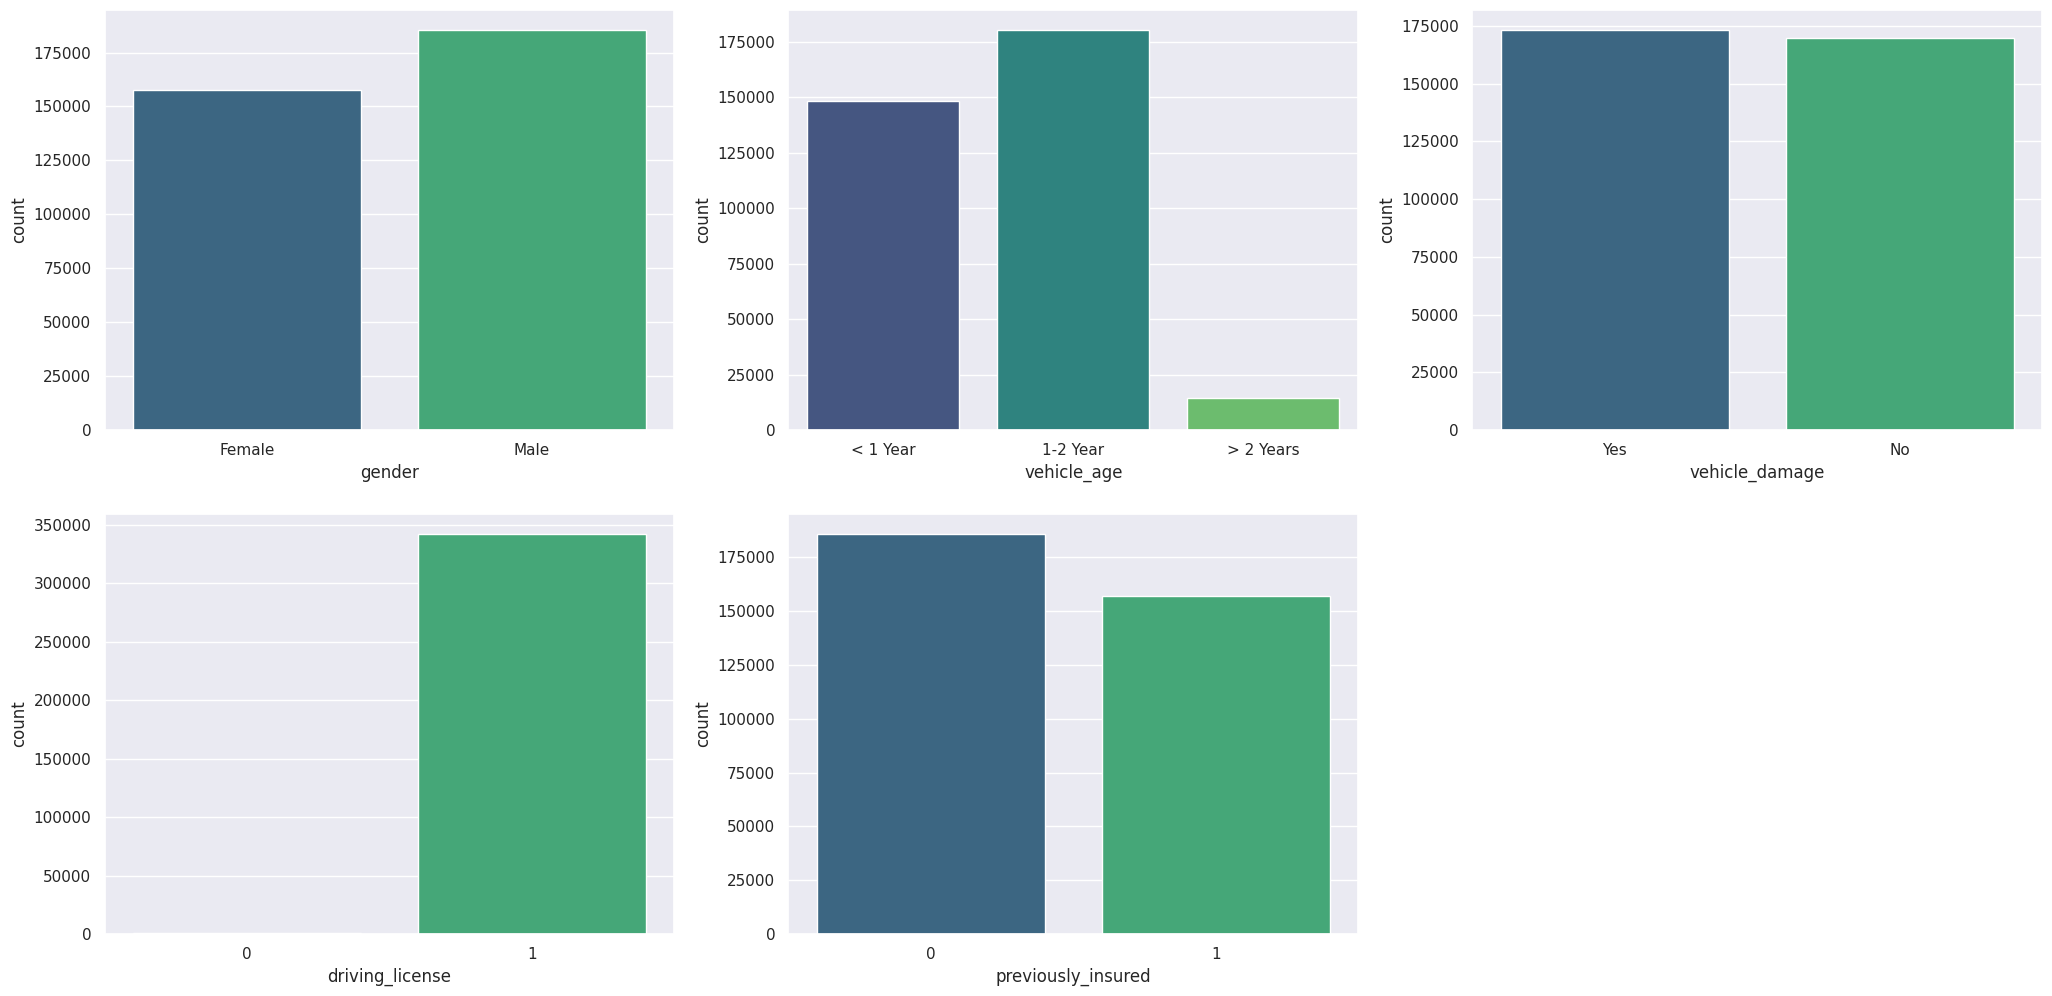

In [16]:
plt.subplot( 2, 3, 1 )
sns.countplot(x='gender', data=df1, palette="viridis")

plt.subplot( 2, 3, 2 )
sns.countplot(x='vehicle_age', data=df1, palette="viridis")

plt.subplot( 2, 3, 3 )
sns.countplot(x='vehicle_damage', data=df1, palette="viridis")

plt.subplot( 2, 3, 4 )
sns.countplot(x='driving_license', data=df1, palette="viridis")

plt.subplot( 2, 3, 5 )
sns.countplot(x='previously_insured', data=df1, palette="viridis")



<Axes: xlabel='region_code', ylabel='count'>

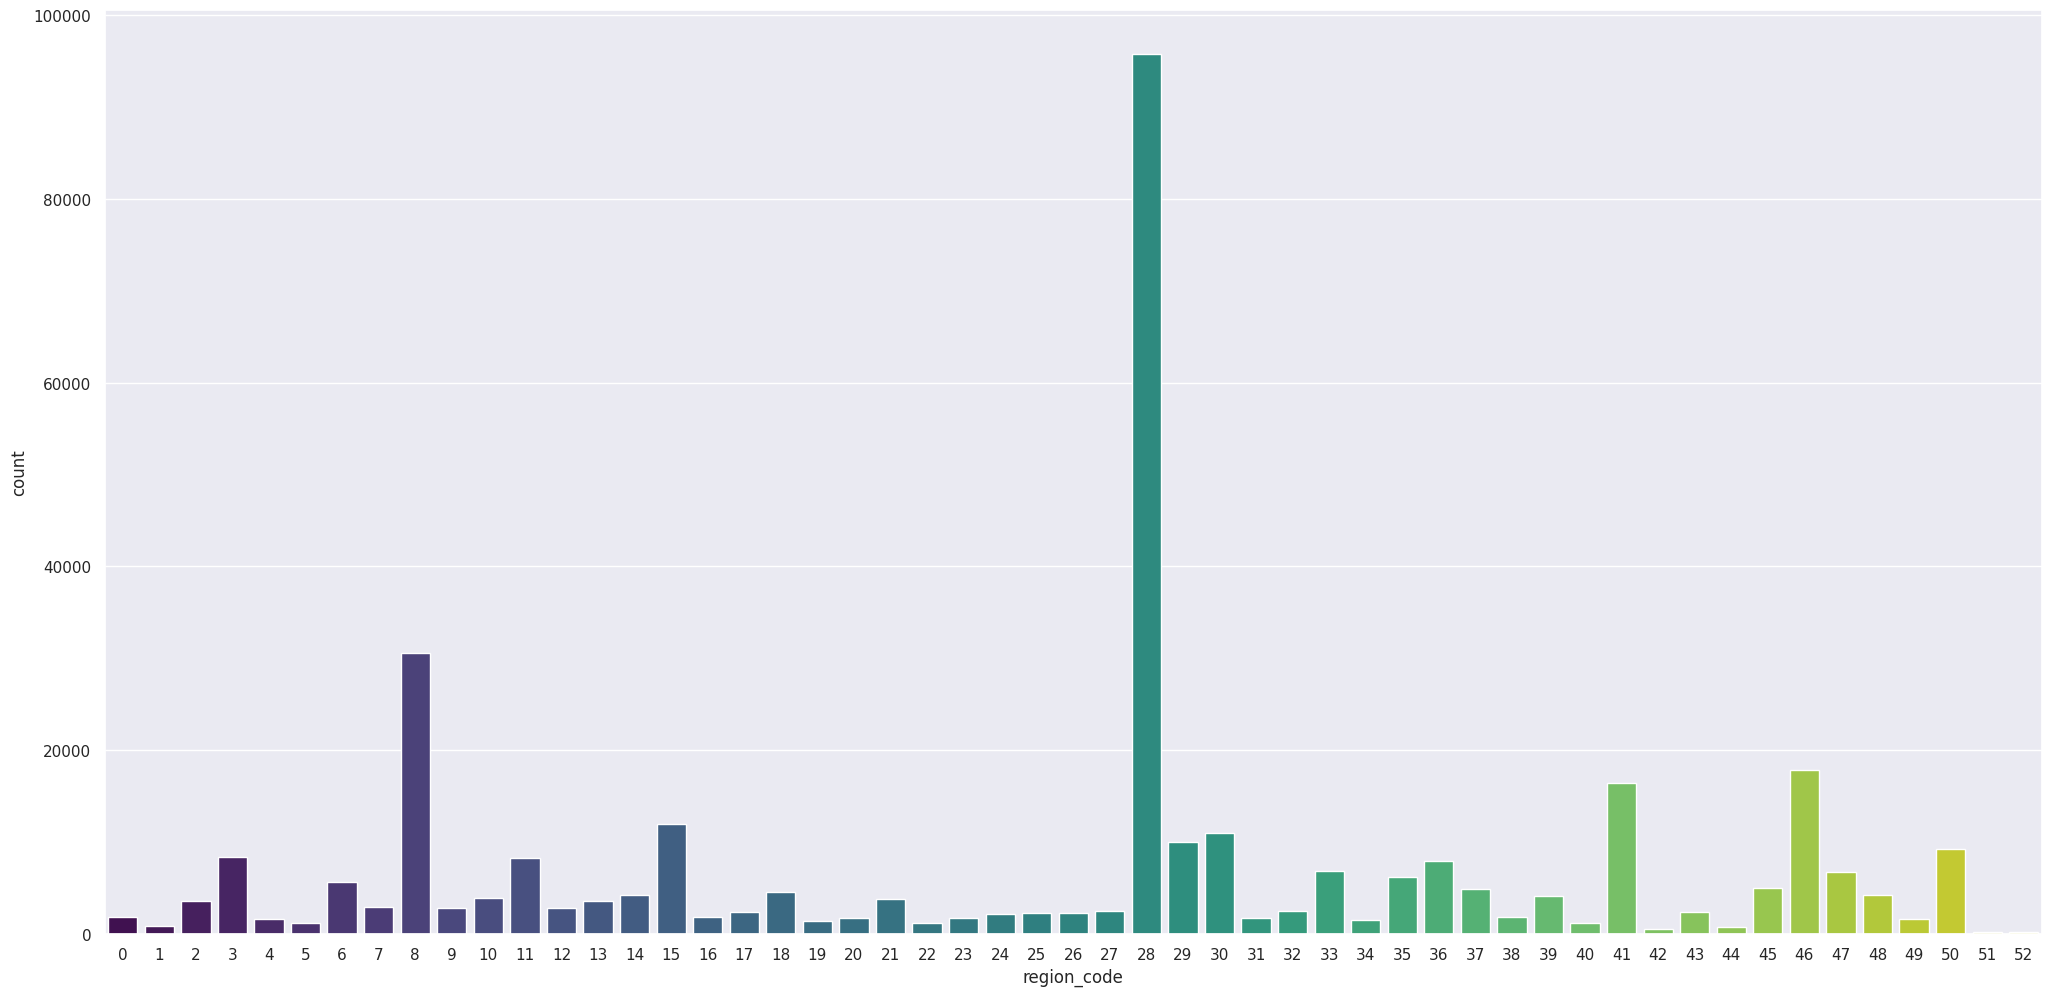

In [17]:
sns.countplot(x='region_code', data=df1, palette="viridis")

<Axes: xlabel='policy_sales_channel', ylabel='count'>

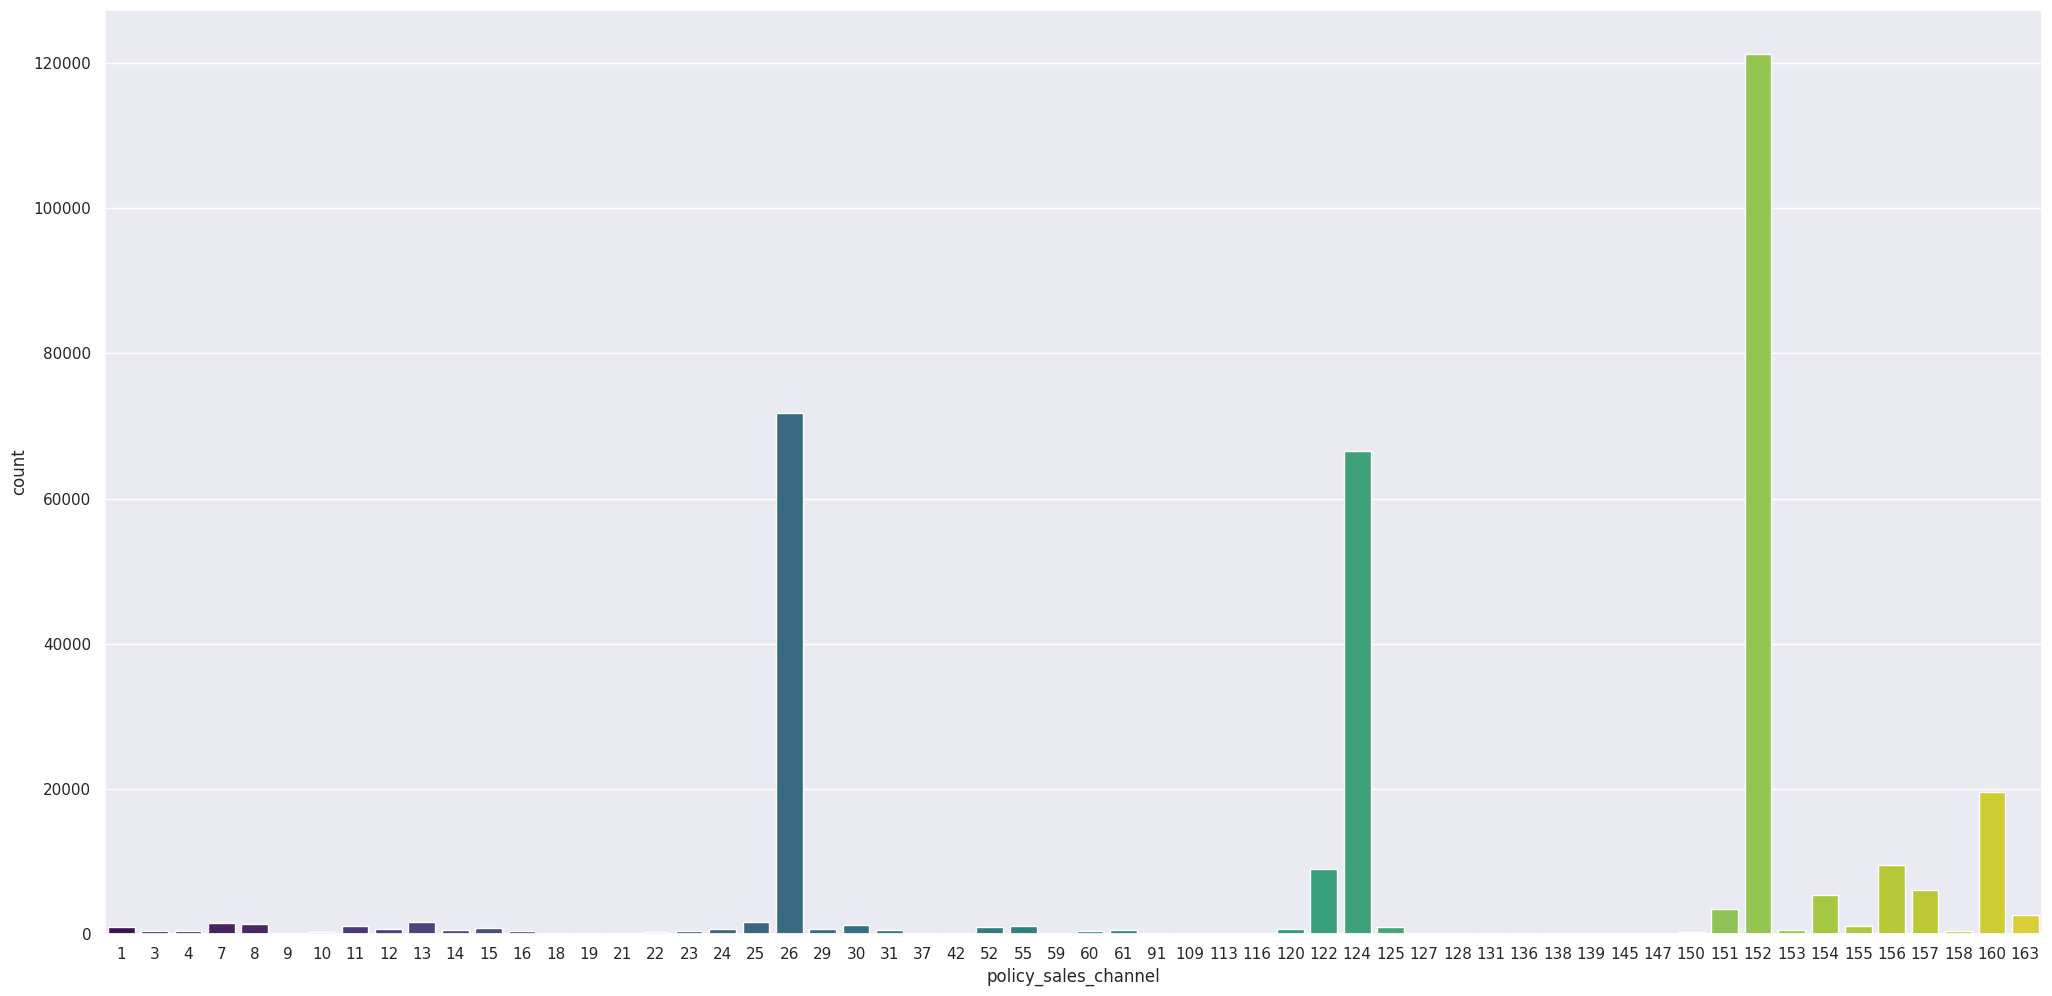

In [18]:
aux_counts = df1['policy_sales_channel'].value_counts()
aux_list = aux_counts[aux_counts > 100].index.tolist()
df_aux = df1[df1['policy_sales_channel'].isin(aux_list)]

sns.countplot(x='policy_sales_channel', data=df_aux, palette="viridis")

# 2.0. Feature Engeneering

In [19]:
df2 = df1.copy()

In [20]:
# vehicle age
df2['vehicle_age'] = df2['vehicle_age'].apply( lambda x: 'over_2_years' if x == '> 2 Years' else
                                                         'between_1_2_year' if x == '1-2 Year' else
                                                         'below_1_year')

# vehicle damage
df2['vehicle_damage'] = df2['vehicle_damage'].apply( lambda x: 1 if x == 'Yes' else 0 )

In [21]:
df2.head().T

,339598,133843,323823,136844,86657
id,339599,133844,323824,136845,86658
gender,Female,Female,Male,Male,Male
age,27,24,22,38,54
driving_license,1,1,1,1,1
region_code,28,16,40,8,28
previously_insured,0,0,0,0,1
vehicle_age,below_1_year,below_1_year,below_1_year,between_1_2_year,between_1_2_year
vehicle_damage,1,1,1,1,0
annual_premium,40041.0,31851.0,39126.0,41242.0,25173.0
policy_sales_channel,152,152,152,26,4


# 3.0. Data Filtering

In [22]:
df3 = df2.copy()

# 4.0. Exploratory Data Analysis (EDA)

In [23]:
df4 = df3.copy()

## 4.1. Univariate Analysis

In [24]:
df4.columns

Index(['id', 'gender', 'age', 'driving_license', 'region_code',
       'previously_insured', 'vehicle_age', 'vehicle_damage', 'annual_premium',
       'policy_sales_channel', 'vintage', 'response'],
      dtype='object')

<Axes: xlabel='response', ylabel='age'>

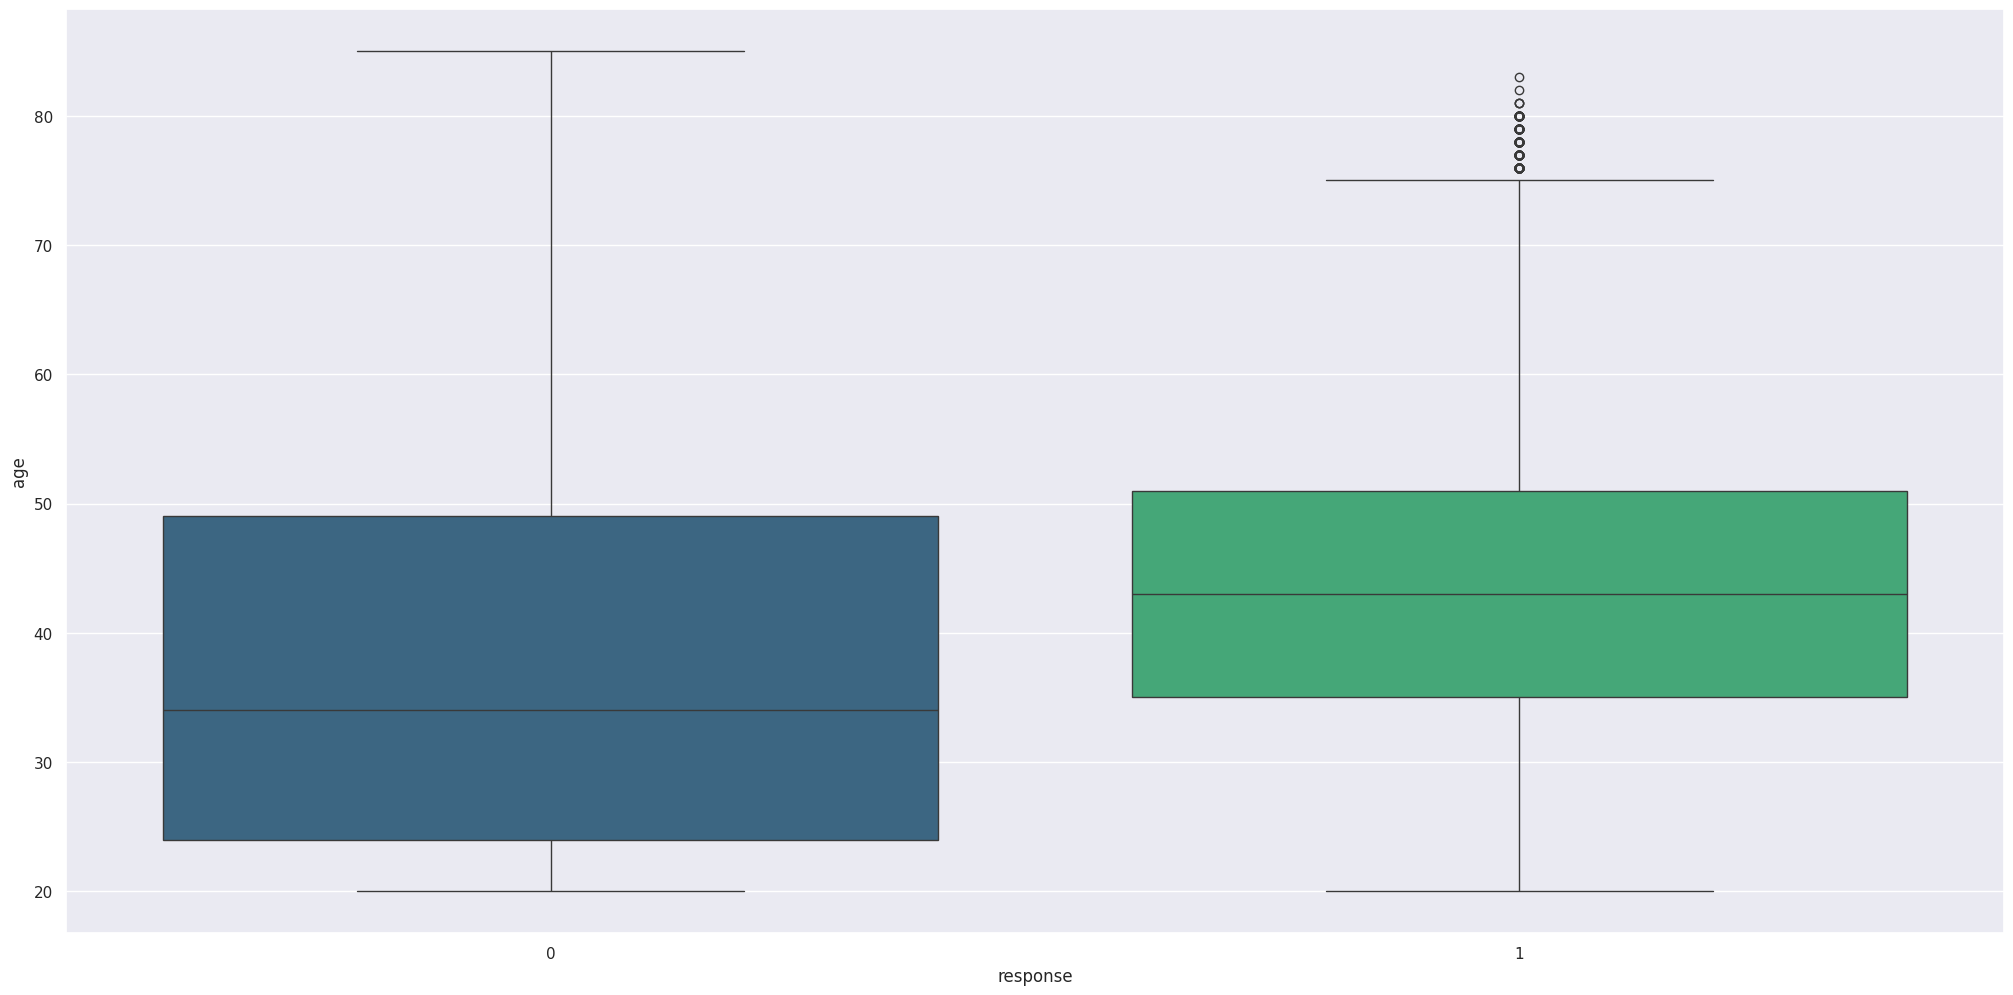

In [25]:
# age
sns.boxplot( x='response', y='age', data=df4, palette="viridis")

[Text(0.5, 1.0, 'Response = 1')]

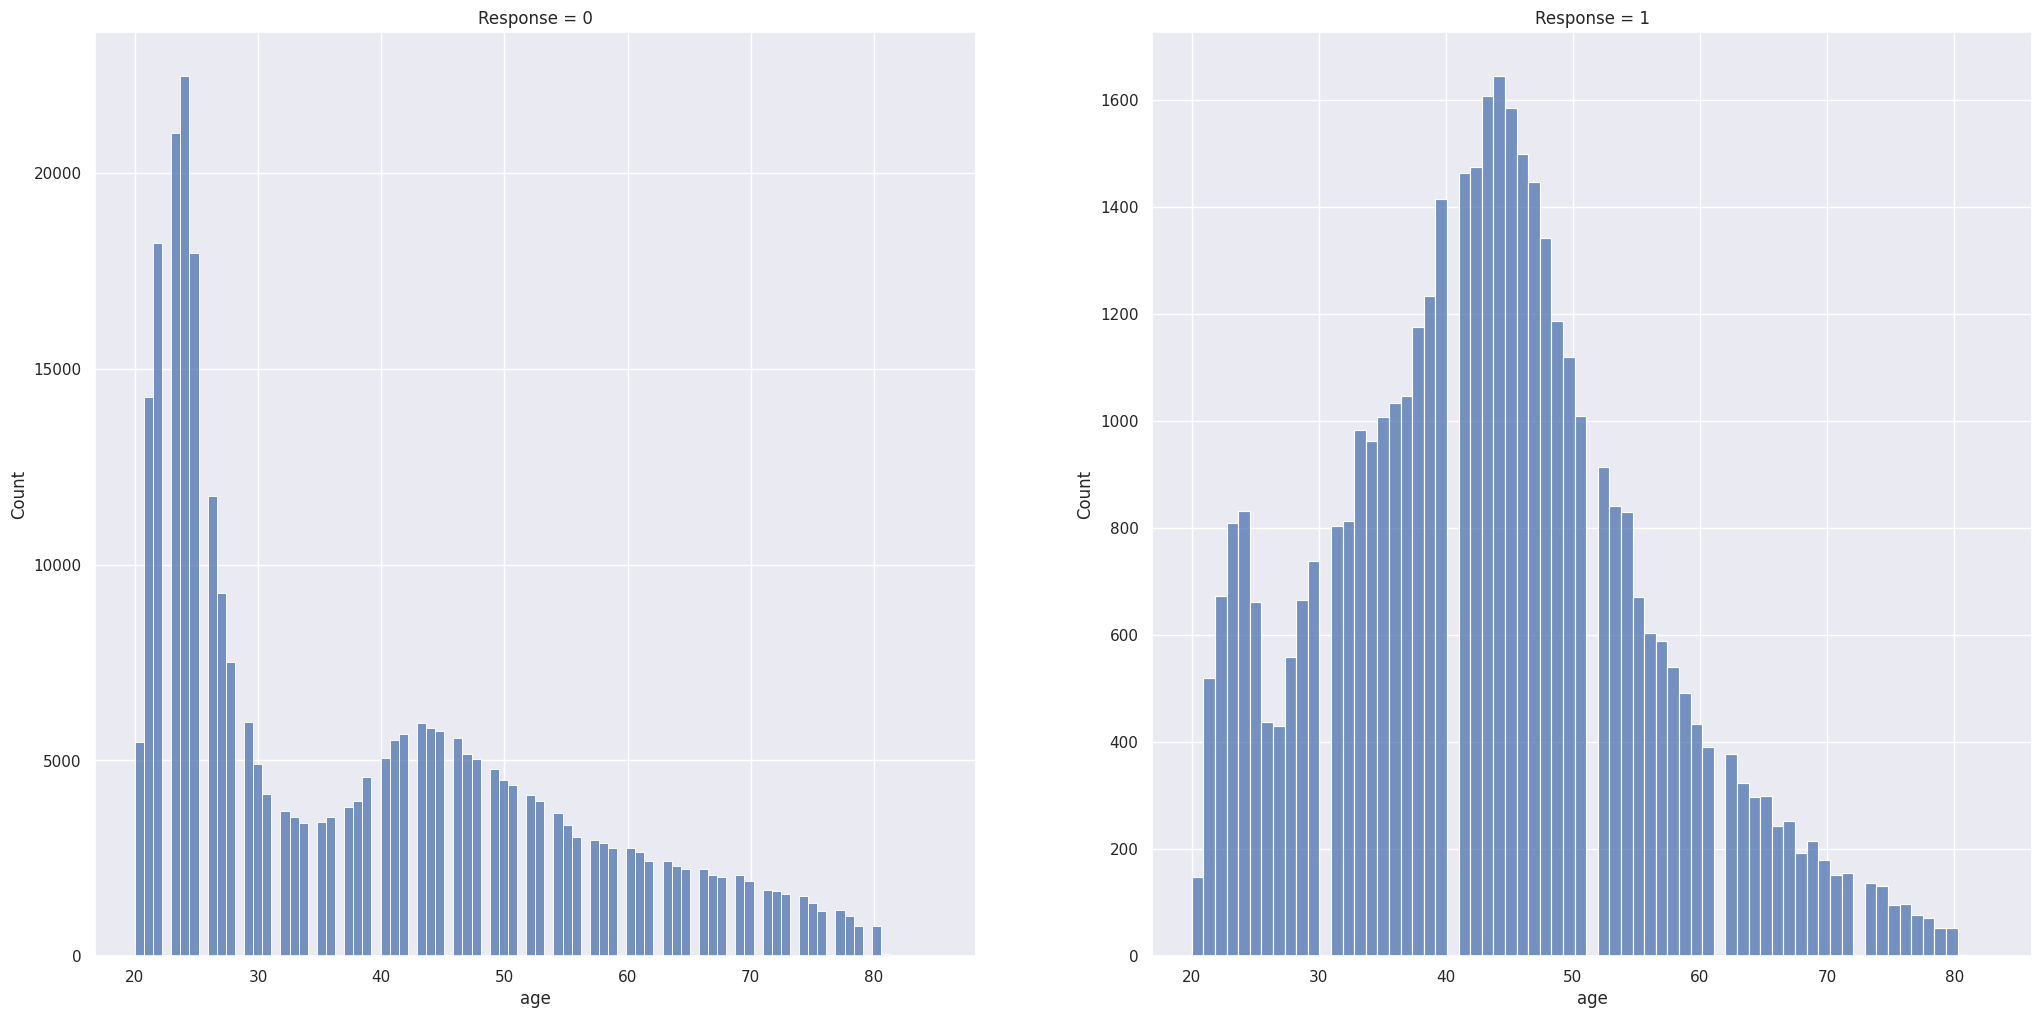

In [26]:
plt.subplot( 1, 2, 1)
aux00 = df4.loc[df4['response'] == 0, 'age']
sns.histplot( aux00 ).set(title='Response = 0')

plt.subplot(1, 2, 2)
aux00 = df4.loc[df4['response'] == 1, 'age']
sns.histplot( aux00 ).set(title='Response = 1')

<Axes: xlabel='response', ylabel='annual_premium'>

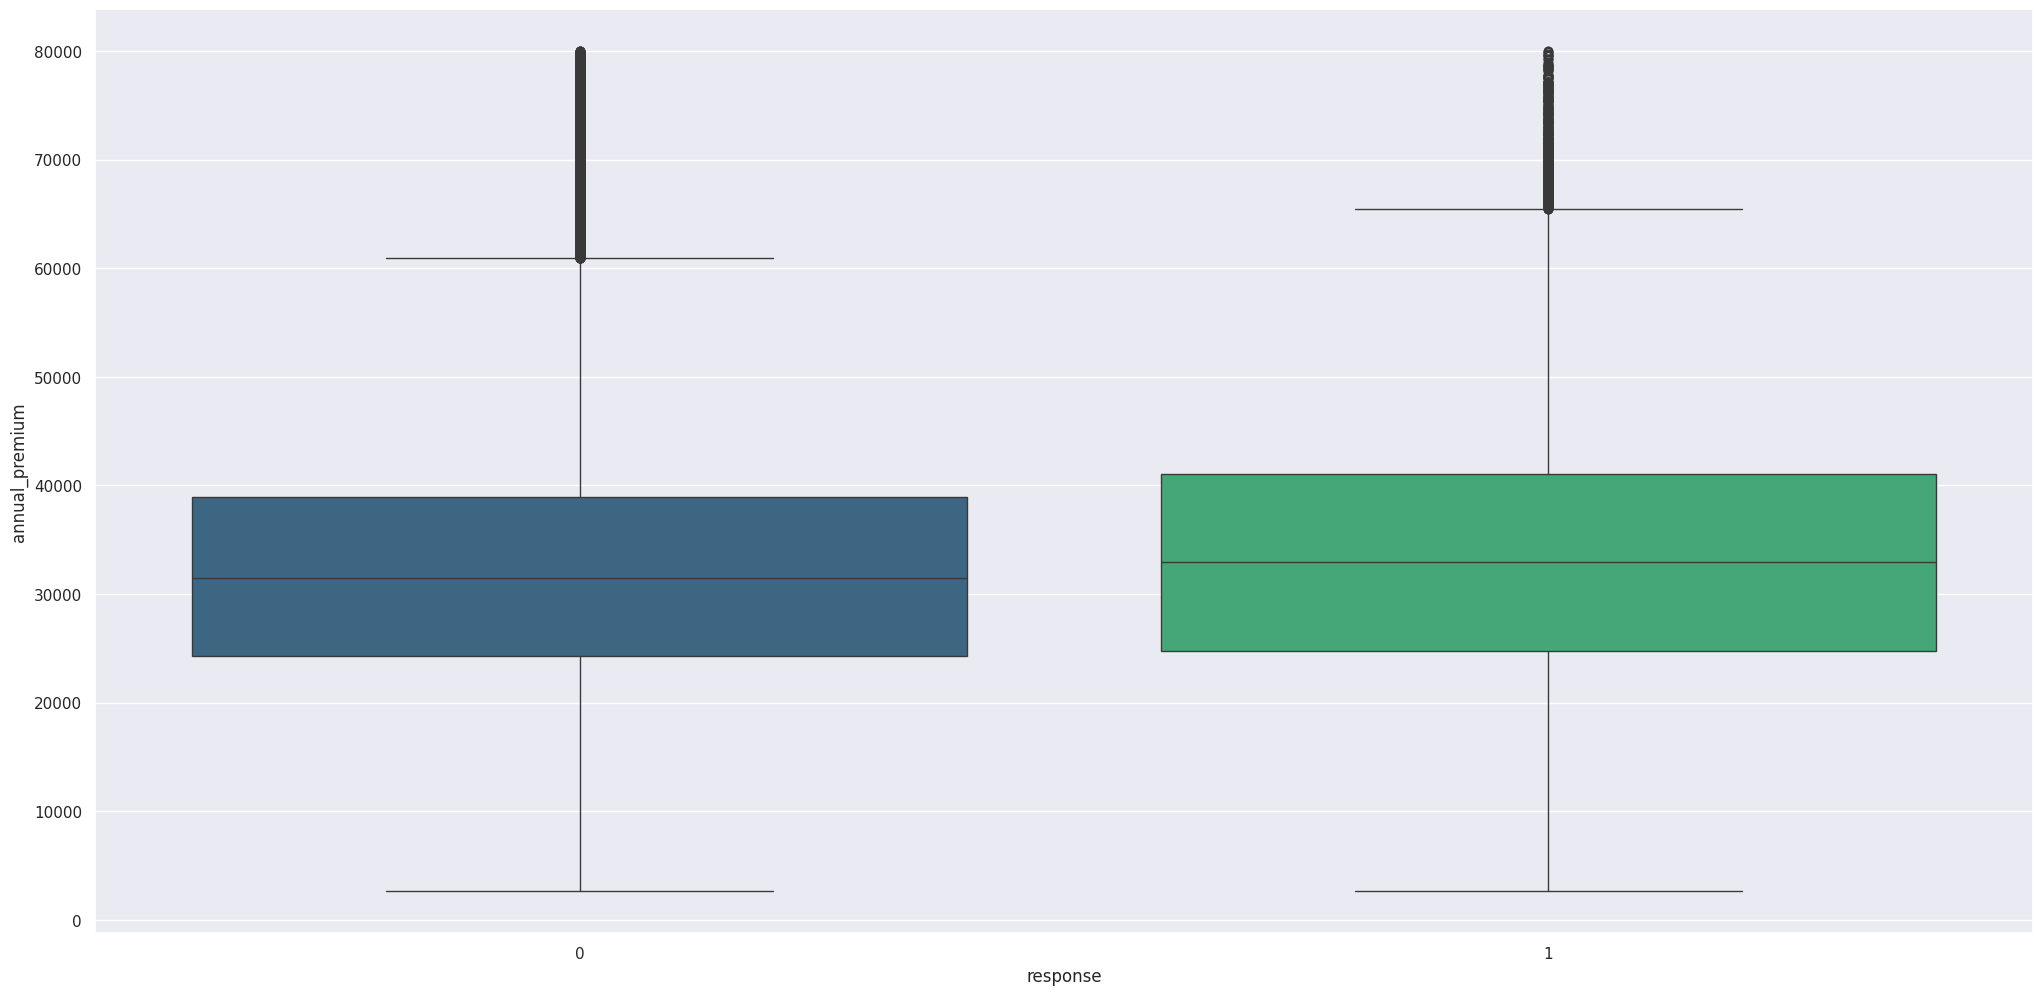

In [27]:
# annual_premium
aux = df4[df4['annual_premium'] < 80000]
sns.boxplot( x='response', y='annual_premium', data=aux, palette="viridis")

[Text(0.5, 1.0, 'Response = 1')]

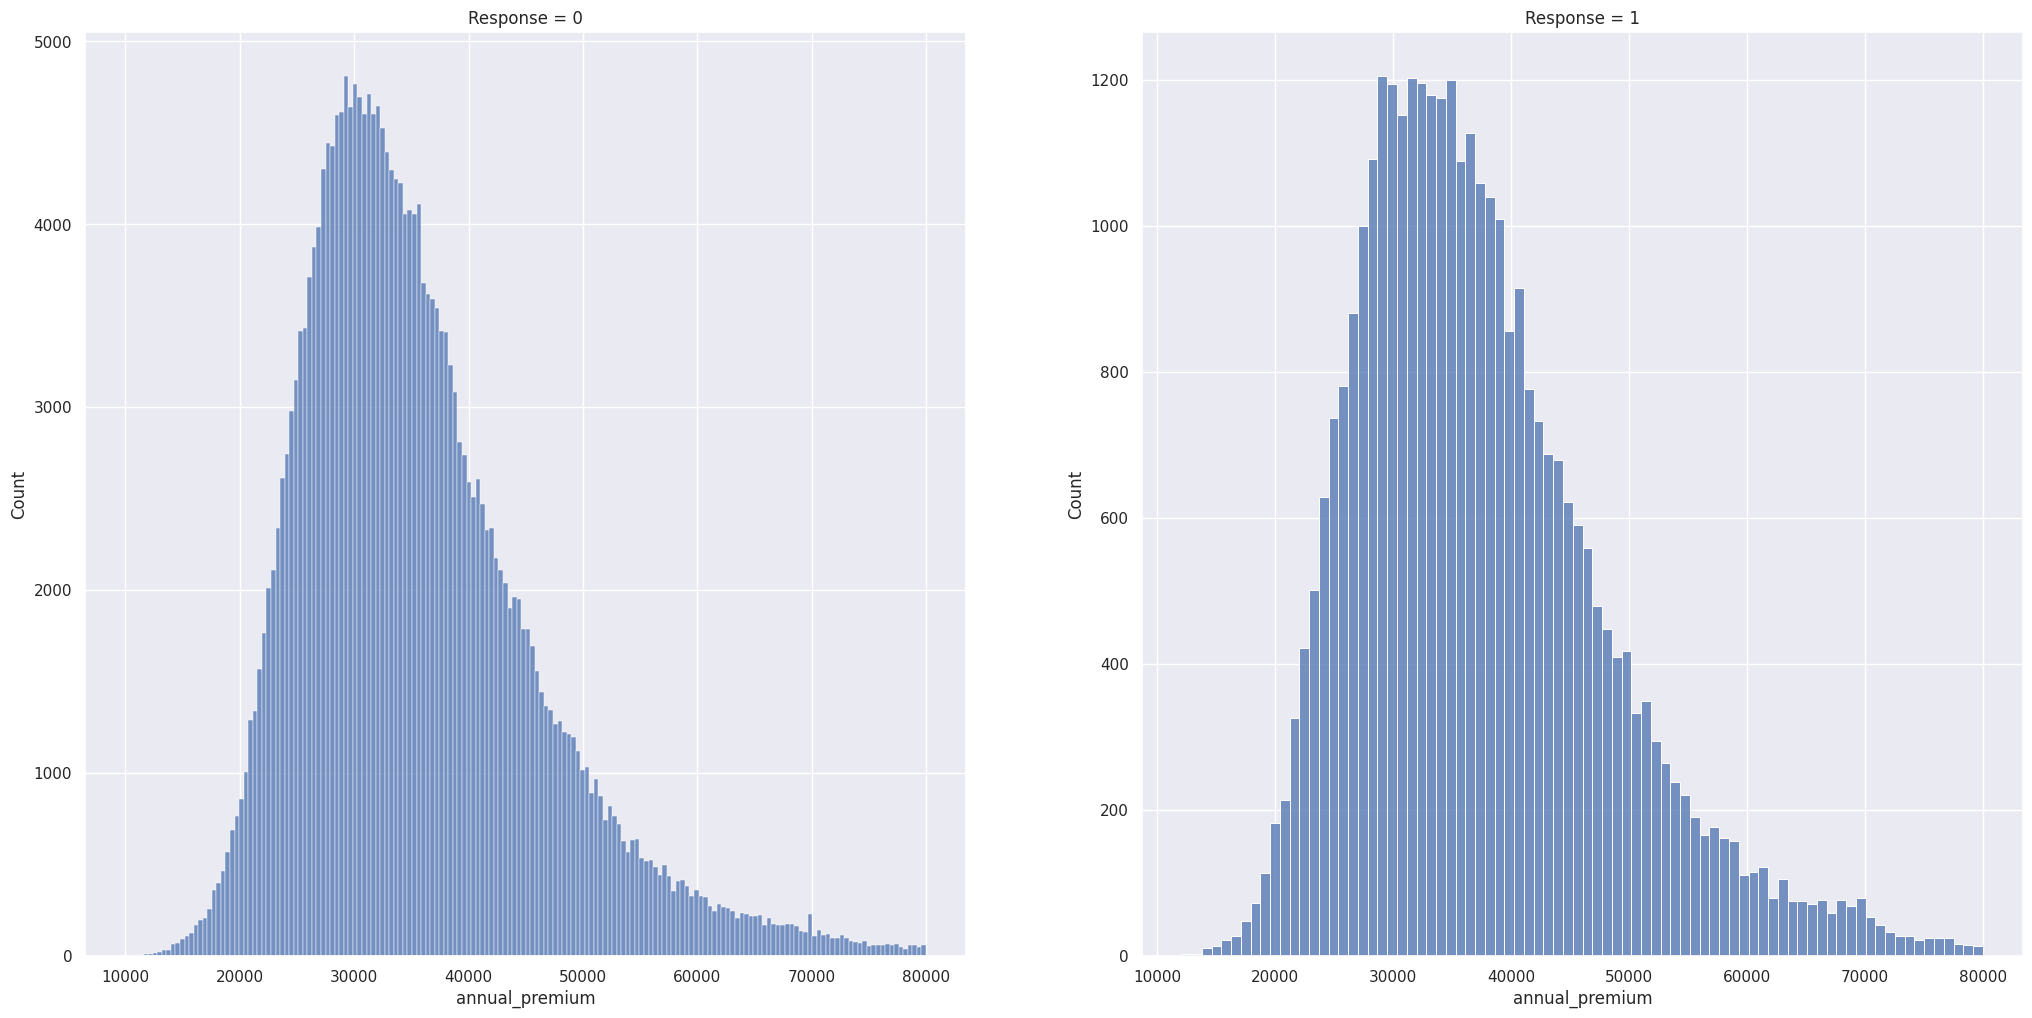

In [28]:
aux = df4[(df4['annual_premium'] > 10000) & (df4['annual_premium'] < 80000)]

plt.subplot( 1, 2, 1)
aux00 = aux.loc[aux['response'] == 0, 'annual_premium']
sns.histplot( aux00 ).set(title='Response = 0')

plt.subplot(1, 2, 2)
aux00 = aux.loc[aux['response'] == 1, 'annual_premium']
sns.histplot( aux00 ).set(title='Response = 1')

<Axes: xlabel='response', ylabel='driving_license'>

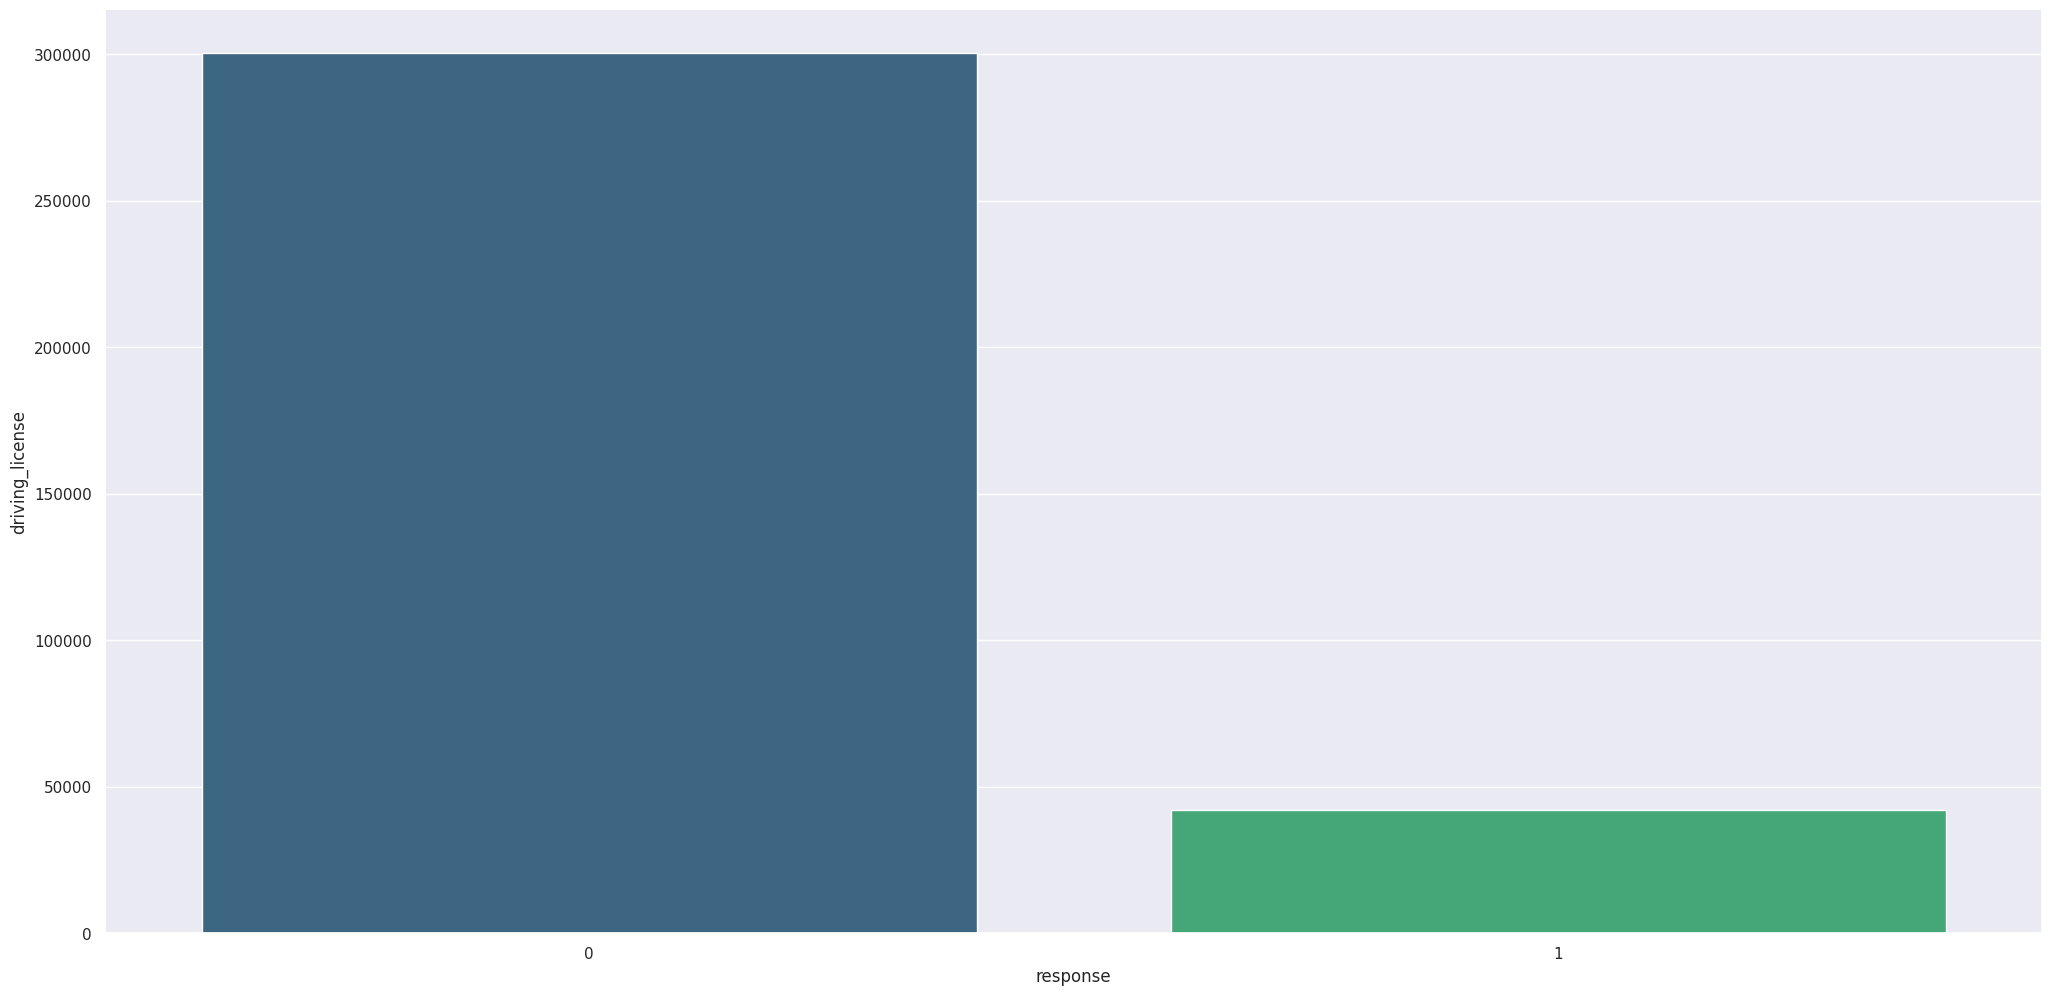

In [29]:
# driving_license
aux = df4[['driving_license', 'response']].groupby( 'response' ).sum().reset_index()
aux.head()
aux['driving_license_perc'] = aux['driving_license'] / aux['driving_license'].sum()

sns.barplot( x='response', y='driving_license', data=aux, palette="viridis")

<Axes: xlabel='region_code', ylabel='id'>

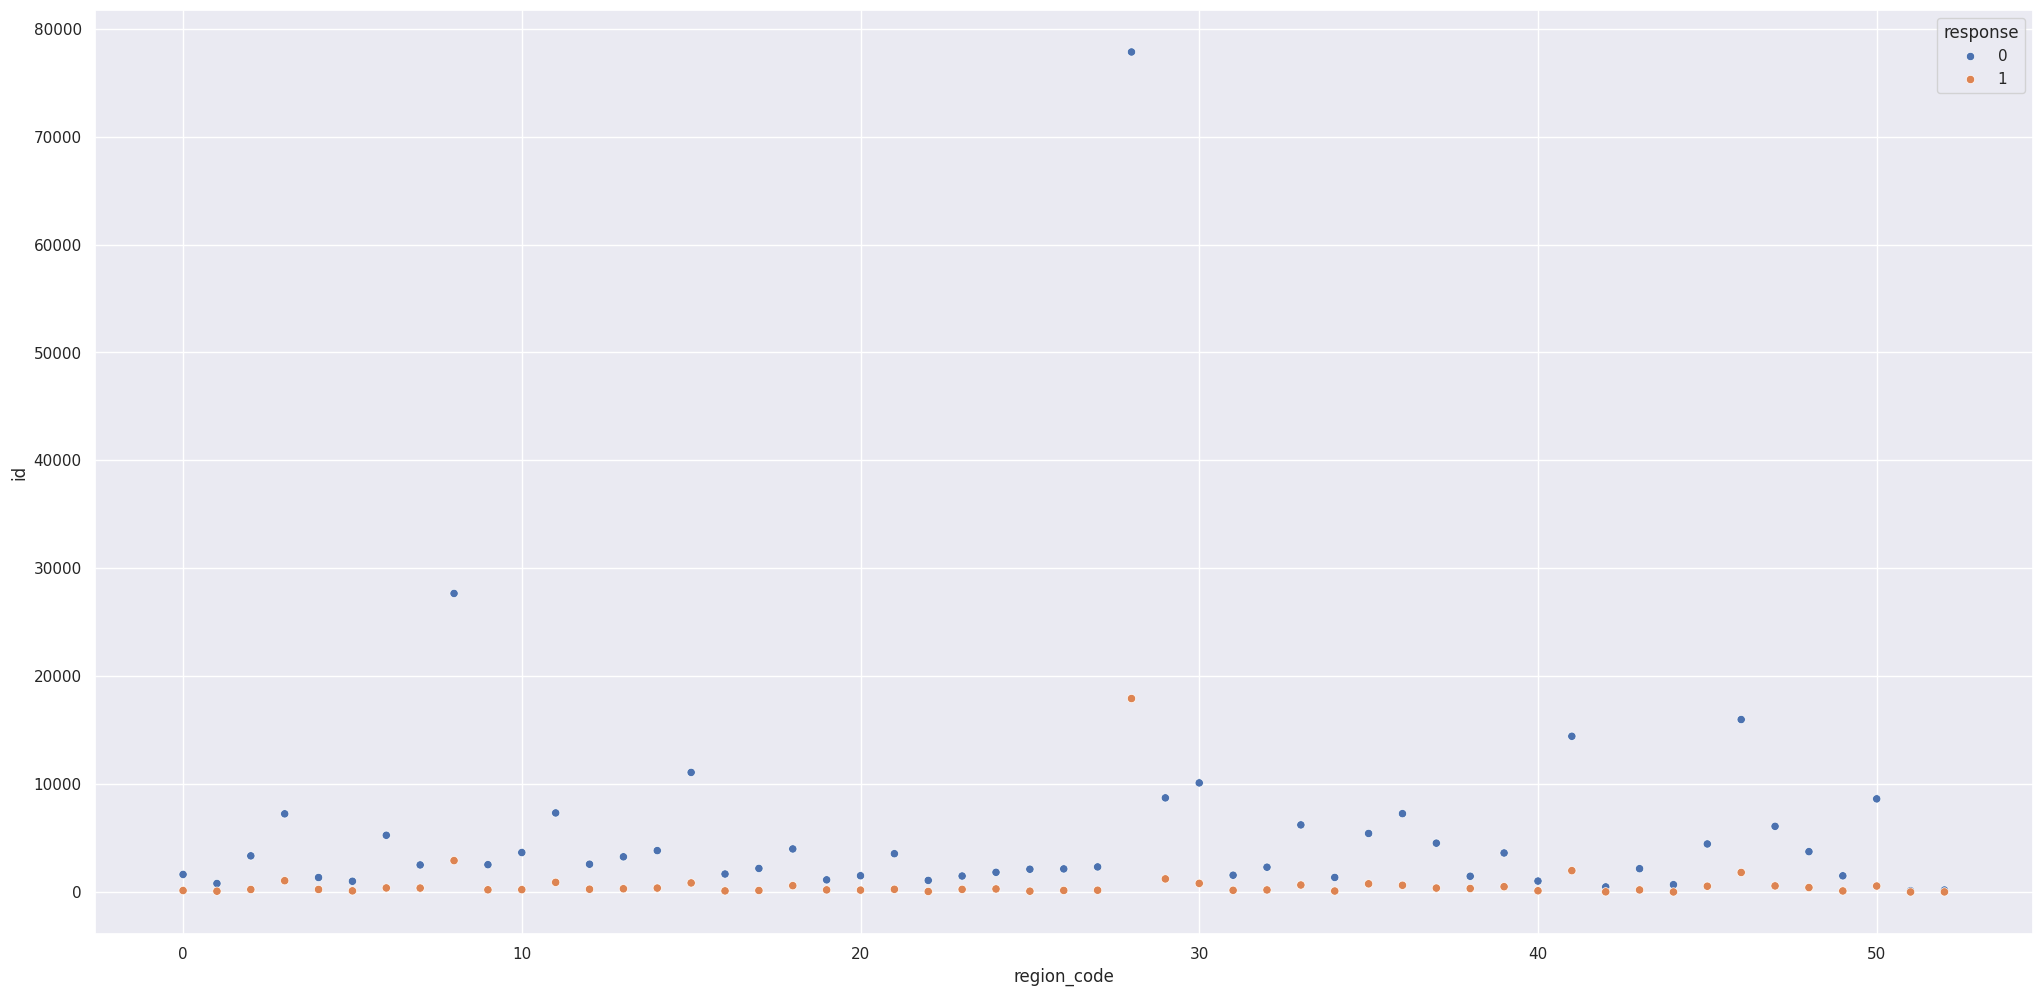

In [30]:
# region_code
aux0 = df4[['id', 'region_code', 'response']].groupby( ['region_code','response'] ).count().reset_index() 

sns.scatterplot( x='region_code', y='id', hue='response', data=aux0)

In [31]:
# gender

In [32]:
# previously_insured
df4[['previously_insured', 'response']].head()
pd.crosstab(df4['previously_insured'], df4['response']).apply( lambda x: x / x.sum(), axis = 1)

response,0,1
previously_insured,,
0,0.774544,0.225456
1,0.999096,0.000904


In [33]:
# vehicle age
df4[['vehicle_age', 'response']].value_counts( normalize=True ).reset_index()

,vehicle_age,response,proportion
0,between_1_2_year,0,0.434198
1,below_1_year,0,0.413524
2,between_1_2_year,1,0.091345
3,over_2_years,0,0.029714
4,below_1_year,1,0.018843
5,over_2_years,1,0.012376


<Axes: xlabel='response', ylabel='policy_sales_channel'>

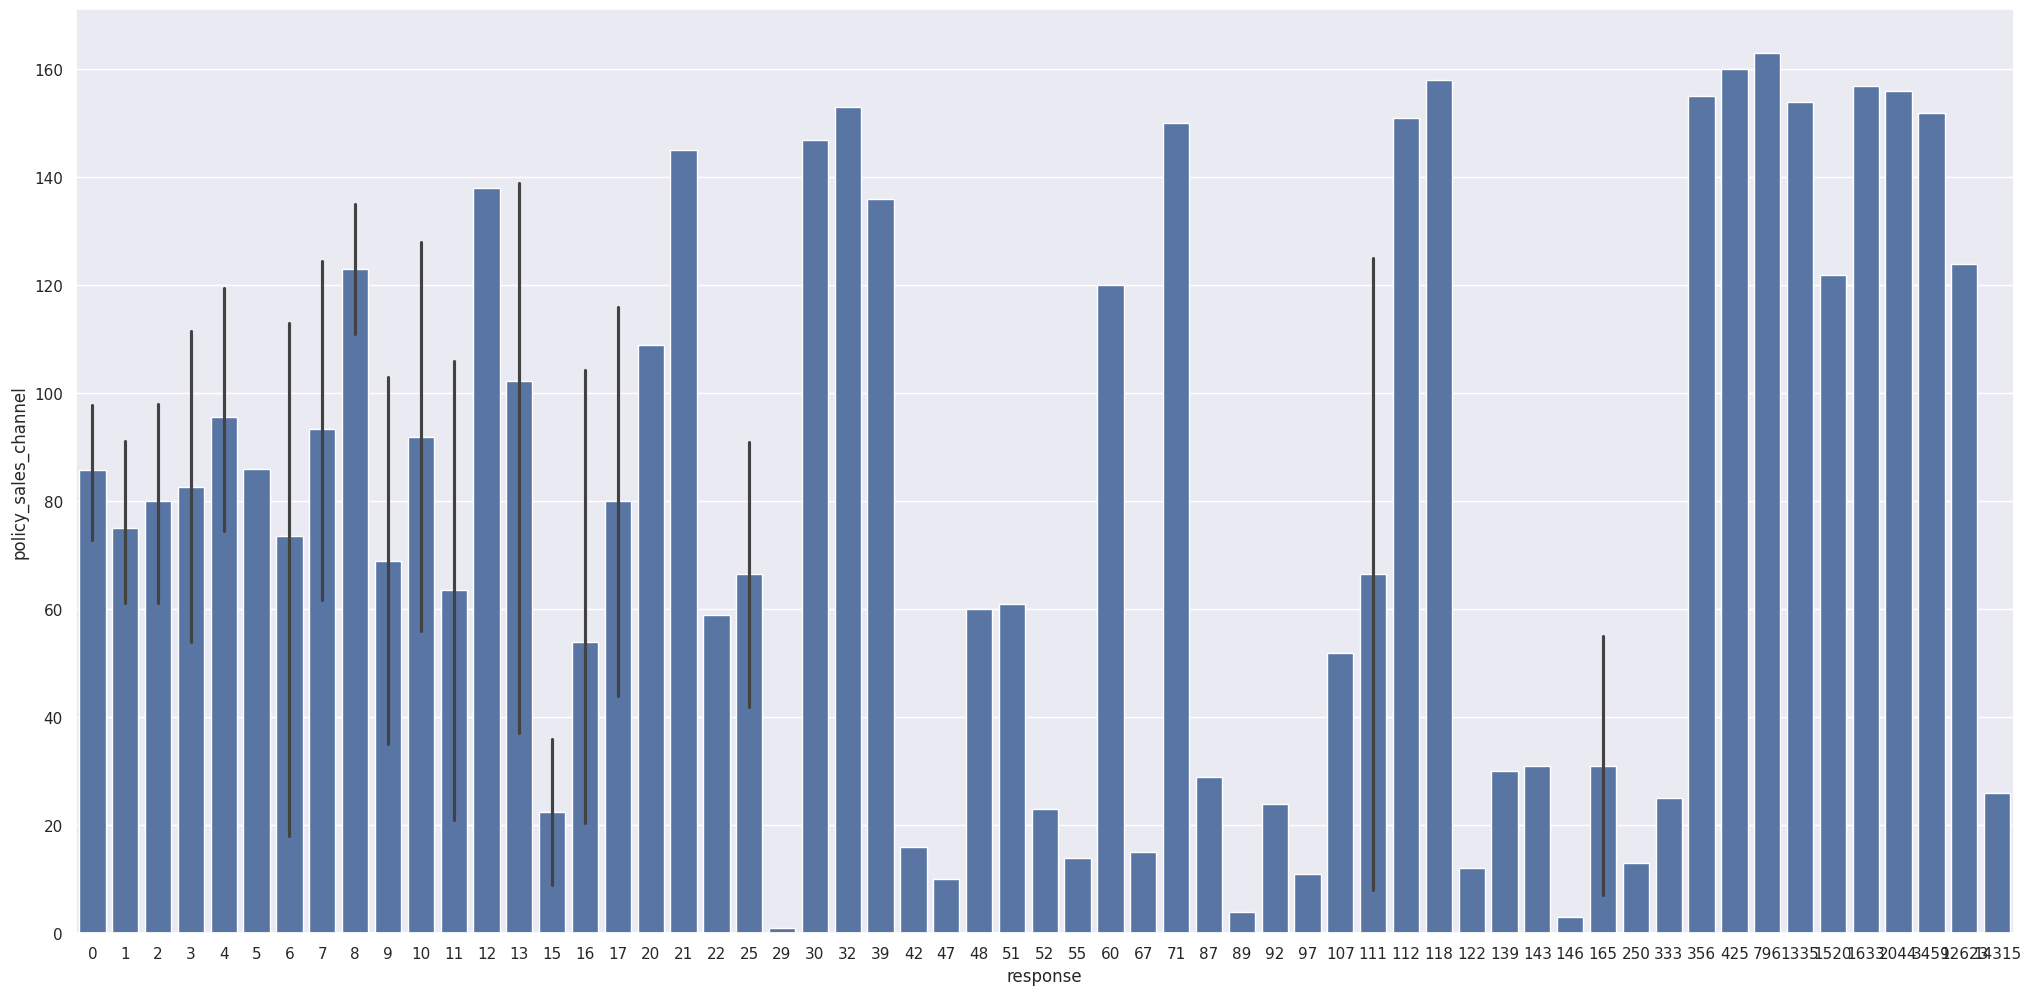

In [34]:
# policy_sales_channel
aux = df4[['policy_sales_channel', 'response']].groupby( 'policy_sales_channel' ).sum().reset_index()
sns.barplot( x='response', y='policy_sales_channel', data=aux)

<Axes: xlabel='response', ylabel='vintage'>

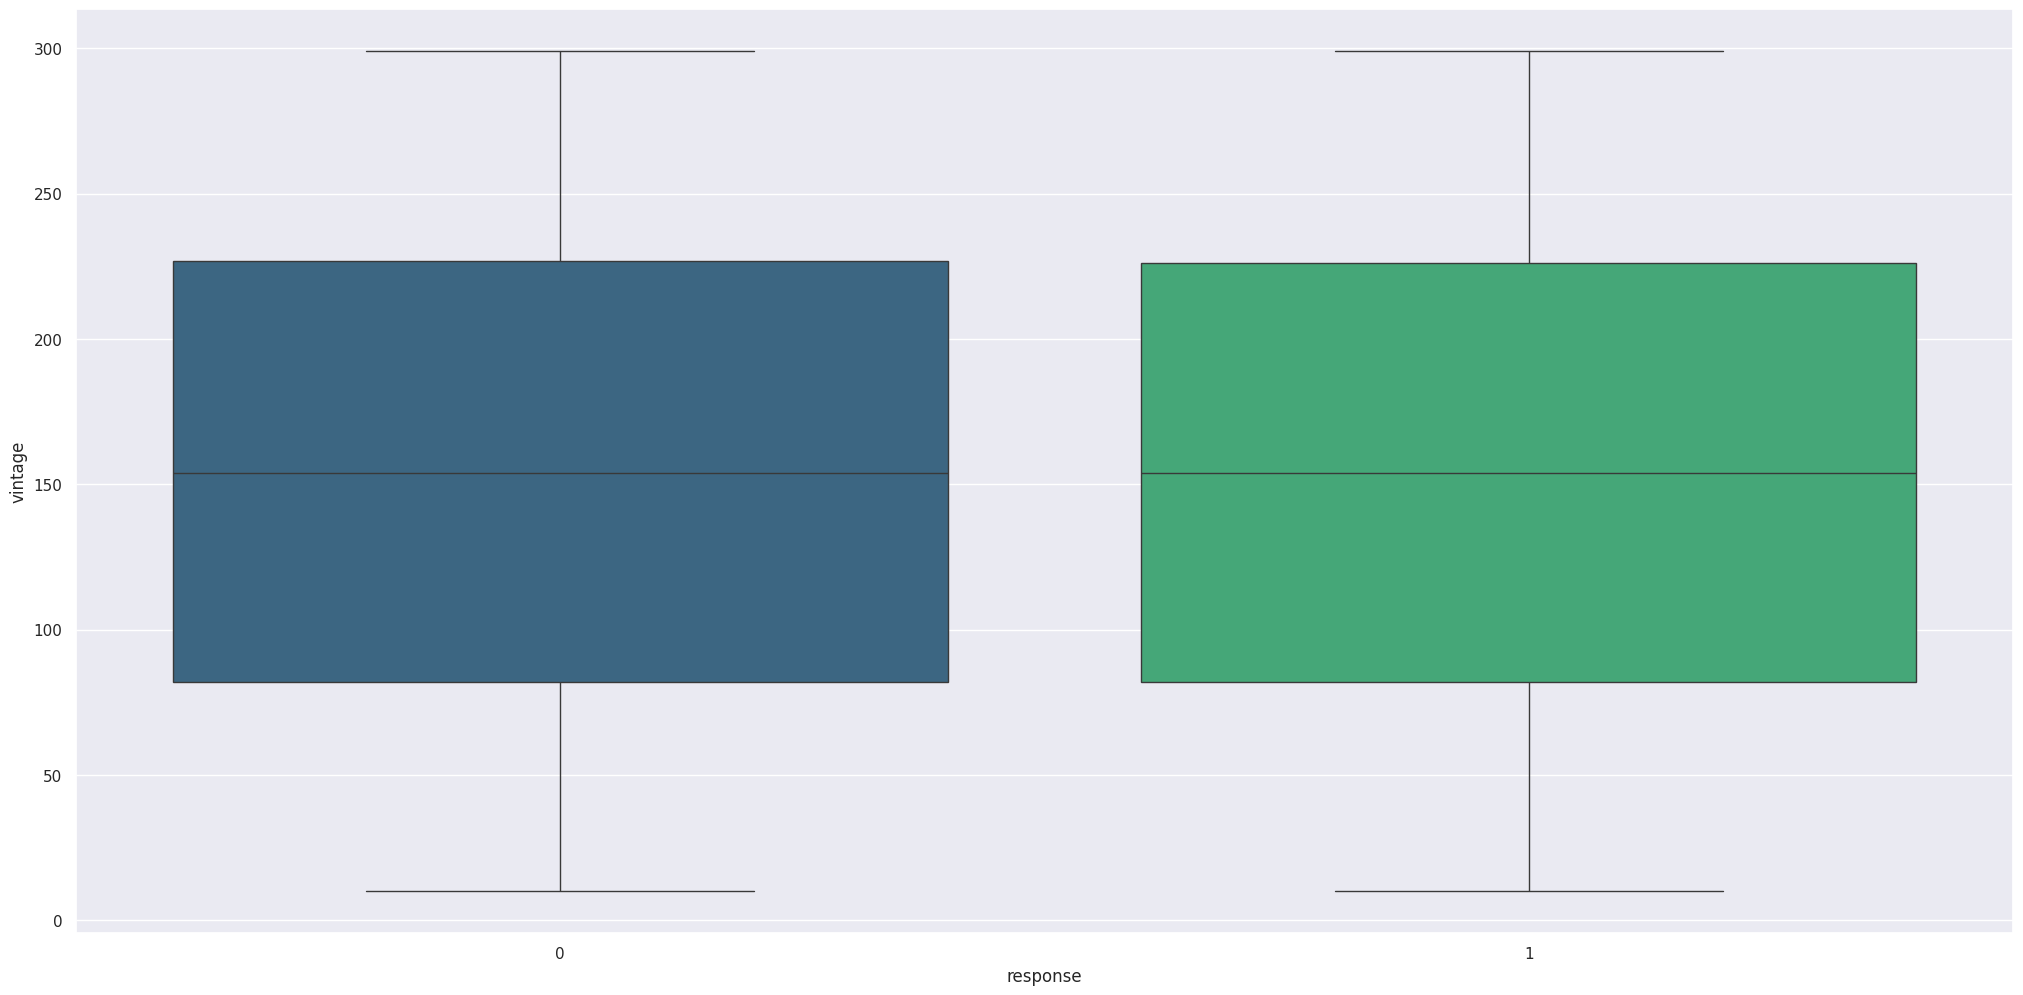

In [35]:
# vintage
sns.boxplot( x='response', y='vintage', data=df4, palette="viridis")

[Text(0.5, 1.0, 'Response = 1')]

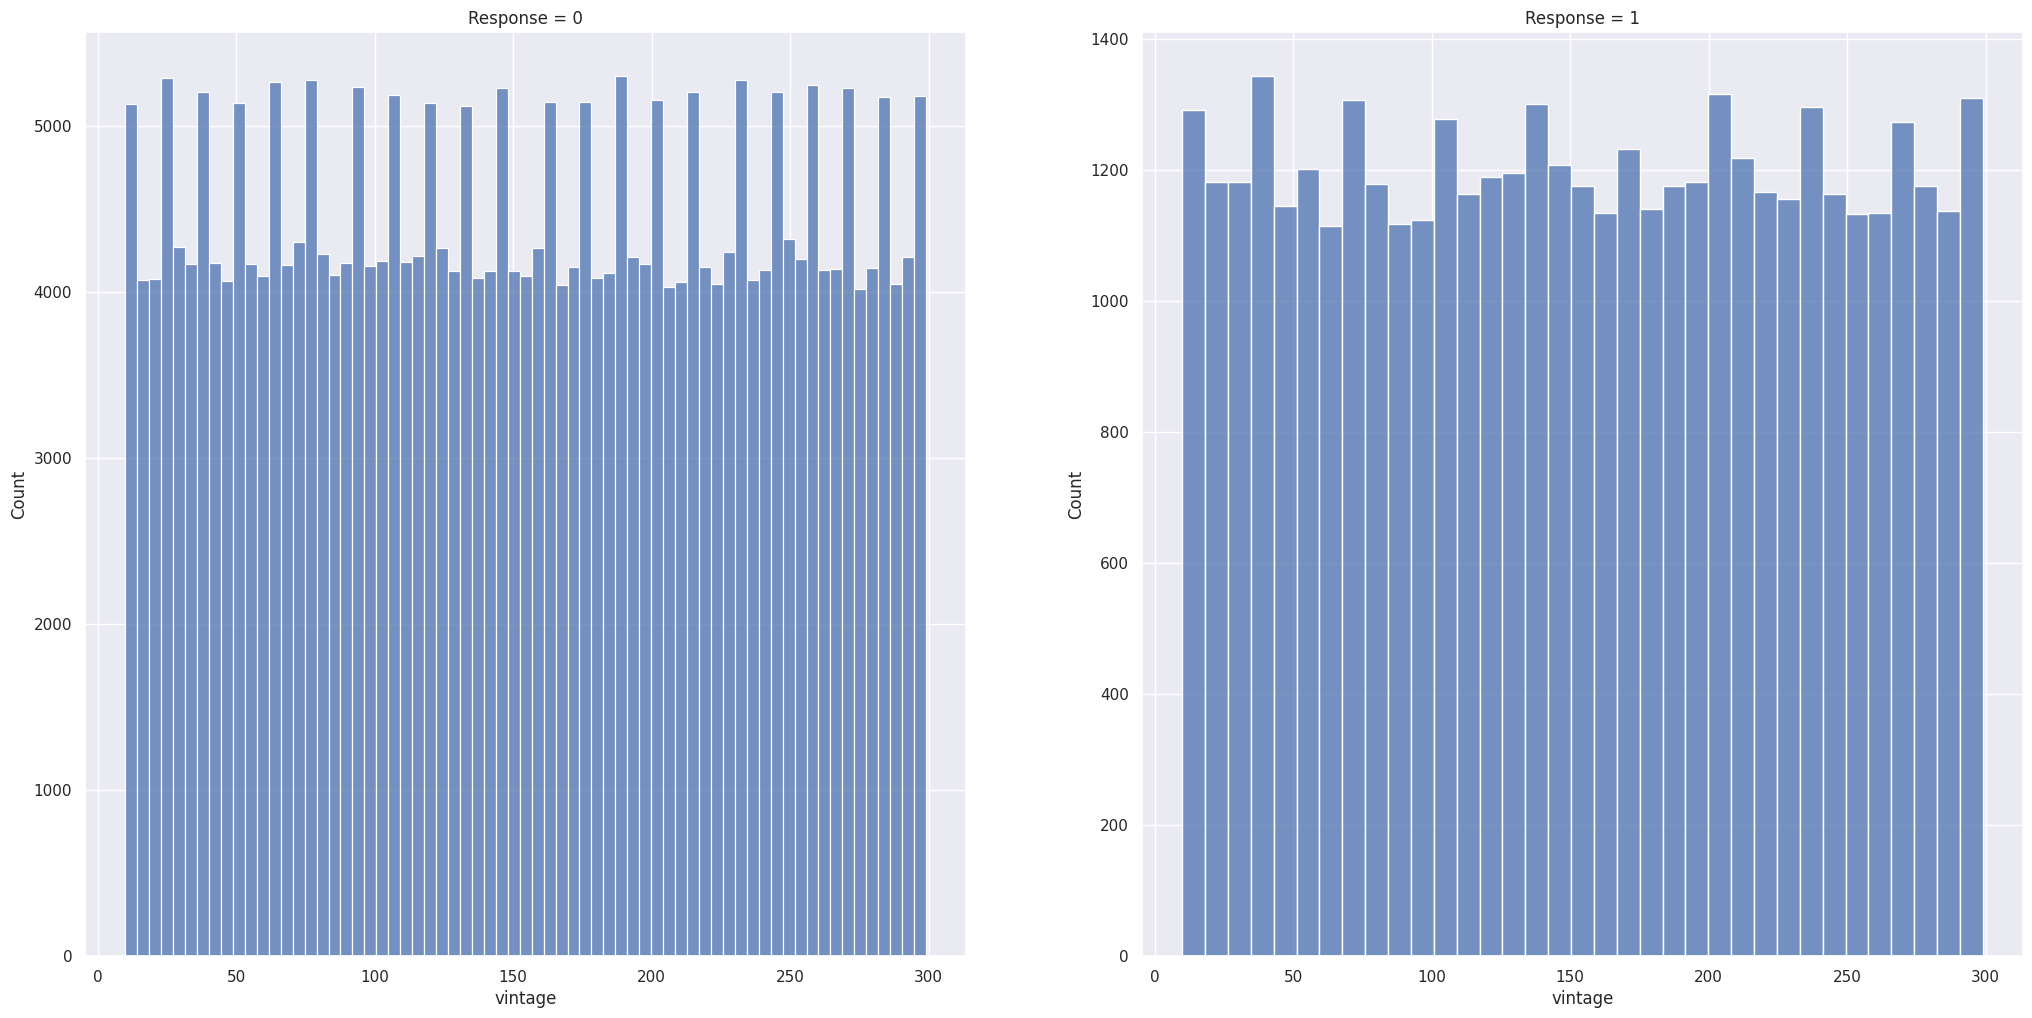

In [36]:
plt.subplot( 1, 2, 1)
aux00 = df4.loc[df4['response'] == 0, 'vintage']
sns.histplot( aux00 ).set(title='Response = 0')

plt.subplot(1, 2, 2)
aux00 = df4.loc[df4['response'] == 1, 'vintage']
sns.histplot( aux00 ).set(title='Response = 1')

# 5.0. Data Preparation

In [37]:
df5 = df4.copy()

## 5.1. Standardization

In [38]:
ss = pp.StandardScaler()

# anual premium - StandarScaler
df5['annual_premium'] = ss.fit_transform( df5[['annual_premium']].values )
pickle.dump( ss, open('../src/features/annual_premium_scaler.pkl', 'wb') )

## 5.2. Rescaling

In [39]:
mms_age = pp.MinMaxScaler()
mms_vintage = pp.MinMaxScaler()

# Age - MinMaxScaler
df5['age'] = mms_age.fit_transform( df5[['age']].values )
pickle.dump( mms_age, open('../src/features/age_scaler.pkl', 'wb') )

# Vintage - MinMaxScaler
df5['vintage'] = mms_vintage.fit_transform( df5[['vintage']].values )
pickle.dump( mms_vintage, open('../src/features/vintage_scaler.pkl', 'wb') )

## 5.3. Transformation

## 5.3.1. Encoding

In [40]:
# gender - One Hot Encoding / Target Encoding
target_encode_gender = df5.groupby( 'gender' )['response'].mean()
df5.loc[:, 'gender'] = df5['gender'].map( target_encode_gender )
pickle.dump( target_encode_gender, open('../src/features/target_encode_gender_scaler.pkl', 'wb') )

# region_code - Target Encoding / Frequency Encoding
target_encode_region_code = df5.groupby( 'region_code' )['response'].mean()
df5.loc[:, 'region_code'] = df5['region_code'].map( target_encode_region_code )
pickle.dump( target_encode_region_code, open('../src/features/target_encode_region_code_scaler.pkl', 'wb') )

# vehicle_age - One Hot Encoding / Frequency Encoding
df5 = pd.get_dummies( df5, prefix='vehicle_age', columns=['vehicle_age'] )

# policy_sales_channel - Target Encoding / Frequency Encoding
fe_policy_sales_channel = df5.groupby( 'policy_sales_channel' ).size() / len( df5 ) 
df5.loc[:, 'policy_sales_channel'] = df5['policy_sales_channel'].map( fe_policy_sales_channel )
pickle.dump( fe_policy_sales_channel, open('../src/features/fe_policy_sales_channel_scaler.pkl', 'wb') )

# 6.0. Feature Selection

## 6.1. Boruta Algorithm

In [41]:
x_train_n = df5.drop( ['id', 'response'], axis=1 ).values
y_train_n = df5['response'].values.ravel()

# Define model
et = en.ExtraTreesClassifier( n_jobs=-1 )

# Define boruta
boruta = bt.BorutaPy( et, n_estimators='auto', verbose=2, random_state=42 ).fit( x_train_n, y_train_n  )

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	10
Iteration: 	9 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	10
Iteration: 	10 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	10
Iteration: 	11 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	10
Iteration: 	12 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	10
Iteration: 	13 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	10
Iteration: 	14 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	10
Iteration: 	15 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	10
Iteration: 	16 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	10
I

In [42]:
cols_selected = boruta.support_.tolist()

# best features
x_train_fs = df5.drop( ['id', 'response'], axis=1 )
cols_selected_boruta = x_train_fs.iloc[:, cols_selected].columns.to_list()

# not selected boruta
cols_not_selected_boruta = list( np.setdiff1d( x_train_fs.columns, cols_selected_boruta ) )

## 6.2. Feature Importance

In [43]:
# model definition
forest = en.ExtraTreesClassifier( n_estimators=250, random_state=0, n_jobs=-1 )

# data preparation
x_train_n = df5.drop( ['id', 'response'], axis=1 )
y_train_n = df5['response'].values
forest.fit( x_train_n, y_train_n )

,n_estimators,250
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,False
,oob_score,False


Feature ranking:
                        feature  importance
0                       vintage    0.275314
0                annual_premium    0.247326
0                           age    0.163346
0                   region_code    0.103101
0                vehicle_damage    0.068488
0          policy_sales_channel    0.058765
0            previously_insured    0.055546
0      vehicle_age_below_1_year    0.014449
0  vehicle_age_between_1_2_year    0.006127
0                        gender    0.004787
0      vehicle_age_over_2_years    0.002268
0               driving_license    0.000483


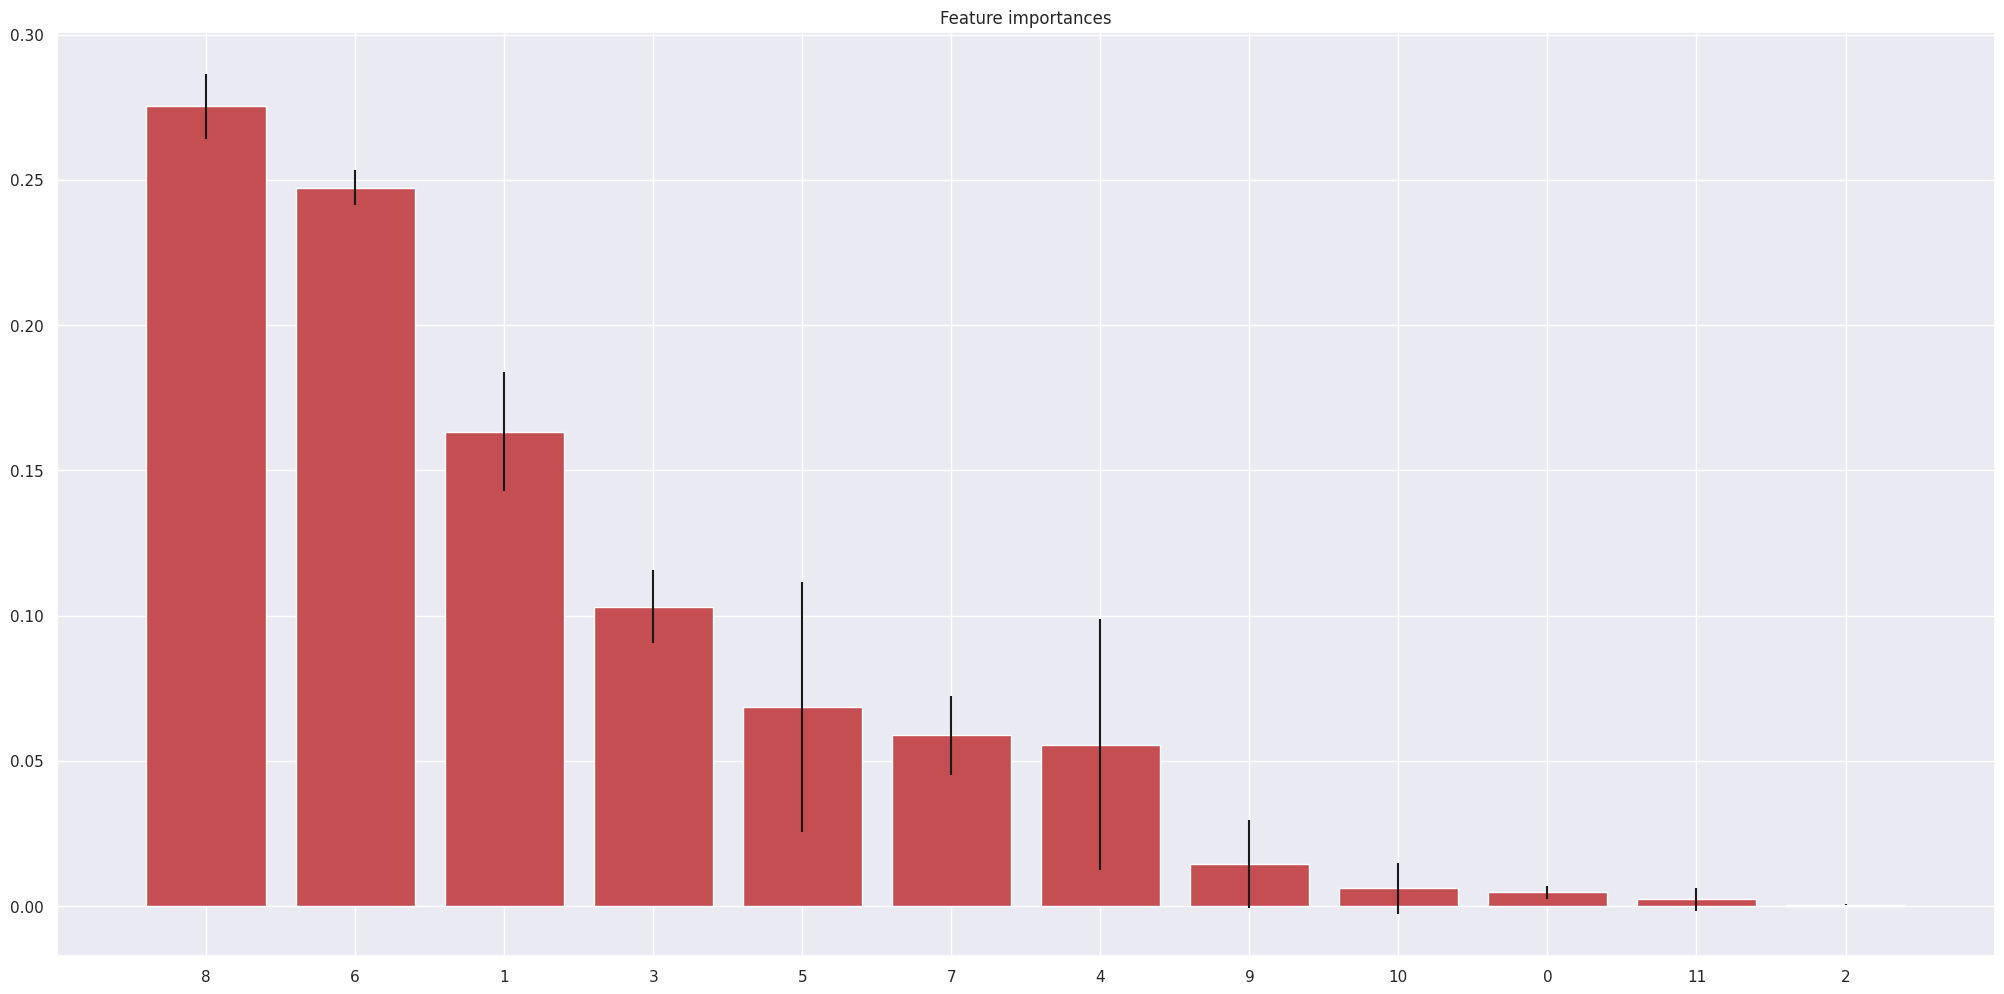

In [44]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
df = pd.DataFrame()
for i, j in zip( x_train_n, forest.feature_importances_ ):
    aux = pd.DataFrame( {'feature': i, 'importance': j}, index=[0] )
    df = pd.concat( [df, aux], axis=0 )
    
print( df.sort_values( 'importance', ascending=False ) )

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(x_train_n.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(x_train_n.shape[1]), indices)
plt.xlim([-1, x_train_n.shape[1]])
plt.show()

# 7.0. Machine Learning Modelling

In [45]:
cols_selected = ['annual_premium', 'vintage', 'age', 'region_code', 'vehicle_damage', 'previously_insured',
                 'policy_sales_channel']

x = df5[ cols_selected ]
y = df5[['response']]

models_performance = []

## 7.1. Logistic Regression

In [46]:
model = lm.LogisticRegression()

df_res = cross_validation( x, y, 5, "Logistic Regression", model, 0.20, verbose=False )

models_performance.append([ df_res['Model Name'].item(), df_res['Precision_at_k'].item(), df_res['Recall_at_k'].item() ])

pd.DataFrame([[ df_res['Model Name'].item(), df_res['Precision_at_k'].item(), df_res['Recall_at_k'].item() ]], columns=['Model Name', 'Precision at k', 'Recall at k'])

,Model Name,Precision at k,Recall at k
0,Logistic Regression,0.29 +/- 0.0,0.47 +/- 0.01


## 7.2. KNN 

In [47]:
model = nh.KNeighborsClassifier()

df_res = cross_validation( x, y, 5, "KNN", model, 0.20, verbose=False )

models_performance.append([ df_res['Model Name'].item(), df_res['Precision_at_k'].item(), df_res['Recall_at_k'].item() ])

pd.DataFrame([[ df_res['Model Name'].item(), df_res['Precision_at_k'].item(), df_res['Recall_at_k'].item() ]], columns=['Model Name', 'Precision at k', 'Recall at k'])

,Model Name,Precision at k,Recall at k
0,KNN,0.3 +/- 0.0,0.48 +/- 0.0


## 7.3. ExtraTrees

In [48]:
model = en.ExtraTreesClassifier(n_estimators=1000, n_jobs=-1)

df_res = cross_validation( x, y, 5, "Extra Trees", model, 0.20, verbose=False )

models_performance.append([ df_res['Model Name'].item(), df_res['Precision_at_k'].item(), df_res['Recall_at_k'].item() ])

pd.DataFrame([[ df_res['Model Name'].item(), df_res['Precision_at_k'].item(), df_res['Recall_at_k'].item() ]], columns=['Model Name', 'Precision at k', 'Recall at k'])

,Model Name,Precision at k,Recall at k
0,Extra Trees,0.31 +/- 0.0,0.51 +/- 0.01


## 7.4. Random Forest

In [49]:
model = en.RandomForestClassifier(n_estimators=1000, n_jobs=-1)

df_res = cross_validation( x, y, 5, "Random Forest", model, 0.20, verbose=False )

models_performance.append([ df_res['Model Name'].item(), df_res['Precision_at_k'].item(), df_res['Recall_at_k'].item() ])

pd.DataFrame([[ df_res['Model Name'].item(), df_res['Precision_at_k'].item(), df_res['Recall_at_k'].item() ]], columns=['Model Name', 'Precision at k', 'Recall at k'])

,Model Name,Precision at k,Recall at k
0,Random Forest,0.32 +/- 0.0,0.52 +/- 0.0


## 7.5. XGBoost

In [50]:
model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='error')

df_res = cross_validation( x, y, 5, "XGBoost", model, 0.20, verbose=False )

models_performance.append([ df_res['Model Name'].item(), df_res['Precision_at_k'].item(), df_res['Recall_at_k'].item() ])

pd.DataFrame([[ df_res['Model Name'].item(), df_res['Precision_at_k'].item(), df_res['Recall_at_k'].item() ]], columns=['Model Name', 'Precision at k', 'Recall at k'])

,Model Name,Precision at k,Recall at k
0,XGBoost,0.35 +/- 0.0,0.57 +/- 0.0


## 7.6. Performance Comparison

In [51]:
df_models_performance = pd.DataFrame(models_performance, columns=['Model Name', 'Precision at k', 'Recall at k'])
df_models_performance

,Model Name,Precision at k,Recall at k
0,Logistic Regression,0.29 +/- 0.0,0.47 +/- 0.01
1,KNN,0.3 +/- 0.0,0.48 +/- 0.0
2,Extra Trees,0.31 +/- 0.0,0.51 +/- 0.01
3,Random Forest,0.32 +/- 0.0,0.52 +/- 0.0
4,XGBoost,0.35 +/- 0.0,0.57 +/- 0.0


# 8.0. Hyper Parameter Fine Tuning

## 8.1. Random Search 

In [52]:
param = {
    'n_estimators': [50, 100, 200, 300, 500, 1000, 2000],
    'eta': [0.01, 0.03, 0.05],
    'max_depth': [3, 5, 9],
    'subsample': [0.1, 0.5, 0.7],
    'colsample_bytree': [0.3, 0.7, 0.9],
    'min_child_weight': [3, 8, 15]
}

MAX_EVAL = 10

In [53]:
import random

final_result = pd.DataFrame()

for i in range( MAX_EVAL ):
    # choose values for parameters randomly
    hp = { k: random.sample( v, 1)[0] for k, v in param.items()}
    print( hp )
    
    # model
    model_xgb = xgb.XGBClassifier(objective='binary:logistic',
                                  eval_metric='error',
                                  n_estimators=hp['n_estimators'],
                                  eta=hp['eta'],
                                  max_depth=hp['max_depth'],
                                  subsample=hp['subsample'],
                                  colsample_bytree=hp['colsample_bytree'],
                                  min_child_weight=hp['min_child_weight'] )
    
    # performance
    result = cross_validation(x, y, 5, 'XGBoost', model_xgb, 0.20, verbose=False) 
    final_result = pd.concat([final_result, result])


final_result    

{'n_estimators': 50, 'eta': 0.03, 'max_depth': 9, 'subsample': 0.5, 'colsample_bytree': 0.7, 'min_child_weight': 15}
{'n_estimators': 500, 'eta': 0.03, 'max_depth': 9, 'subsample': 0.5, 'colsample_bytree': 0.9, 'min_child_weight': 8}
{'n_estimators': 200, 'eta': 0.01, 'max_depth': 9, 'subsample': 0.5, 'colsample_bytree': 0.3, 'min_child_weight': 3}
{'n_estimators': 50, 'eta': 0.05, 'max_depth': 3, 'subsample': 0.5, 'colsample_bytree': 0.7, 'min_child_weight': 8}
{'n_estimators': 200, 'eta': 0.05, 'max_depth': 3, 'subsample': 0.7, 'colsample_bytree': 0.3, 'min_child_weight': 15}
{'n_estimators': 2000, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.1, 'colsample_bytree': 0.9, 'min_child_weight': 8}
{'n_estimators': 50, 'eta': 0.05, 'max_depth': 9, 'subsample': 0.7, 'colsample_bytree': 0.7, 'min_child_weight': 3}
{'n_estimators': 50, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.7, 'colsample_bytree': 0.9, 'min_child_weight': 3}
{'n_estimators': 100, 'eta': 0.05, 'max_depth': 5, 'subsample': 0

,Model Name,Precision_at_k,Recall_at_k
0,XGBoost,0.35 +/- 0.0,0.57 +/- 0.01
0,XGBoost,0.35 +/- 0.0,0.57 +/- 0.01
0,XGBoost,0.35 +/- 0.01,0.57 +/- 0.01
0,XGBoost,0.34 +/- 0.0,0.56 +/- 0.01
0,XGBoost,0.35 +/- 0.0,0.57 +/- 0.01
0,XGBoost,0.35 +/- 0.0,0.57 +/- 0.01
0,XGBoost,0.35 +/- 0.0,0.57 +/- 0.01
0,XGBoost,0.35 +/- 0.0,0.57 +/- 0.0
0,XGBoost,0.35 +/- 0.0,0.57 +/- 0.01
0,XGBoost,0.35 +/- 0.0,0.57 +/- 0.0


## 8.2 Final Model

In [73]:
df8_test = df_test.copy()

### 8.2.1. Test Data Cleaning

In [74]:
# 1.1. Rename Columns
cols_new = ['id', 'gender', 'age', 'driving_license', 'region_code', 'previously_insured', 'vehicle_age', 
            'vehicle_damage', 'annual_premium', 'policy_sales_channel', 'vintage', 'response']

# rename 
df8_test.columns = cols_new


## 1.6. Change Data Types

# region_code
df8_test['region_code'] = df8_test['region_code'].astype(int)

# policy_sales_channel
df8_test['policy_sales_channel'] = df8_test['policy_sales_channel'].astype(int)

### 8.2.2. Test Feature Engneering

In [75]:
## 2.4. Feature Engeneering

# vehicle age
df8_test['vehicle_age'] = df8_test['vehicle_age'].apply( lambda x: 'over_2_years' if x == '> 2 Years' else
                                                         'between_1_2_year' if x == '1-2 Year' else
                                                         'below_1_year')

# vehicle damage
df8_test['vehicle_damage'] = df8_test['vehicle_damage'].apply( lambda x: 1 if x == 'Yes' else 0 )

### 8.2.3. Test Data Preparatation

In [76]:
# 5.0 Data Preparation

## 5.1 Standardziation


ss = pp.StandardScaler()

# anual premium - StandarScaler
df8_test['annual_premium'] = ss.fit_transform( df8_test[['annual_premium']].values )



## 5.2. Reescaling

mms_age = pp.MinMaxScaler()
mms_vintage = pp.MinMaxScaler()

# Age - MinMaxScaler
df8_test['age'] = mms_age.fit_transform( df8_test[['age']].values )

# Vintage - MinMaxScaler
df8_test['vintage'] = mms_vintage.fit_transform( df8_test[['vintage']].values )



## 5.3. Encoding

# gender - One Hot Encoding / Target Encoding
target_encode_gender = df8_test.groupby( 'gender' )['response'].mean()
df8_test.loc[:, 'gender'] = df8_test['gender'].map( target_encode_gender )


# region_code - Target Encoding / Frequency Encoding
target_encode_region_code = df8_test.groupby( 'region_code' )['response'].mean()
df8_test.loc[:, 'region_code'] = df8_test['region_code'].map( target_encode_region_code )


# vehicle_age - One Hot Encoding / Frequency Encoding
df8_test = pd.get_dummies( df8_test, prefix='vehicle_age', columns=['vehicle_age'] )

# policy_sales_channel - Target Encoding / Frequency Encoding
fe_policy_sales_channel = df8_test.groupby( 'policy_sales_channel' ).size() / len( df8_test ) 
df8_test.loc[:, 'policy_sales_channel'] = df8_test['policy_sales_channel'].map( fe_policy_sales_channel )


## 8.3. Final Model

In [77]:
param_tuned = {
    'n_estimators': 200,
    'eta': 0.01,
    'max_depth': 9,
    'subsample': 0.5,
    'colsample_bytree': 0.3,
    'min_child_weight': 3
}

x_test = df8_test[ cols_selected ]
y_test = df8_test[['response']]

In [78]:
model_xgb_tuned = xgb.XGBClassifier(objective='binary:logistic',
                              eval_metric='error',
                              n_estimators=param_tuned['n_estimators'],
                              eta=param_tuned['eta'],
                              max_depth=param_tuned['max_depth'],
                              subsample=param_tuned['subsample'],
                              colsample_bytree=param_tuned['colsample_bytree'],
                              min_child_weight=param_tuned['min_child_weight'] )


# model
m = model_xgb_tuned.fit( x, y )

# prediction
yhat = m.predict_proba( x_test)

df_final = x_test.copy()
df_final['response'] = y_test.copy()

# propensity score
df_final['score'] = yhat[:, 1].tolist()

# sort clients by propensity score
df_final = df_final.sort_values( 'score', ascending=False )

# performance
precisionk, data_precision = precision_at_k( df_final, 0.20 )
recallk, data_recall = recall_at_k(df_final, 0.20)

precisionk = np.round(precisionk , 2 ).astype( str )
recallk = np.round(recallk , 2 ).astype( str )

xgb_result_tuned = pd.DataFrame([['XGBoost', precisionk, recallk]], columns=['Model Name', 'Precision at k', 'Recall at k'])
xgb_result_tuned



,Model Name,Precision at k,Recall at k
0,XGBoost,0.34,0.55


# 9.0. Performance Metrics

In [79]:
df9 = df_final.copy()

## 9.1. Cumulative Gains curve

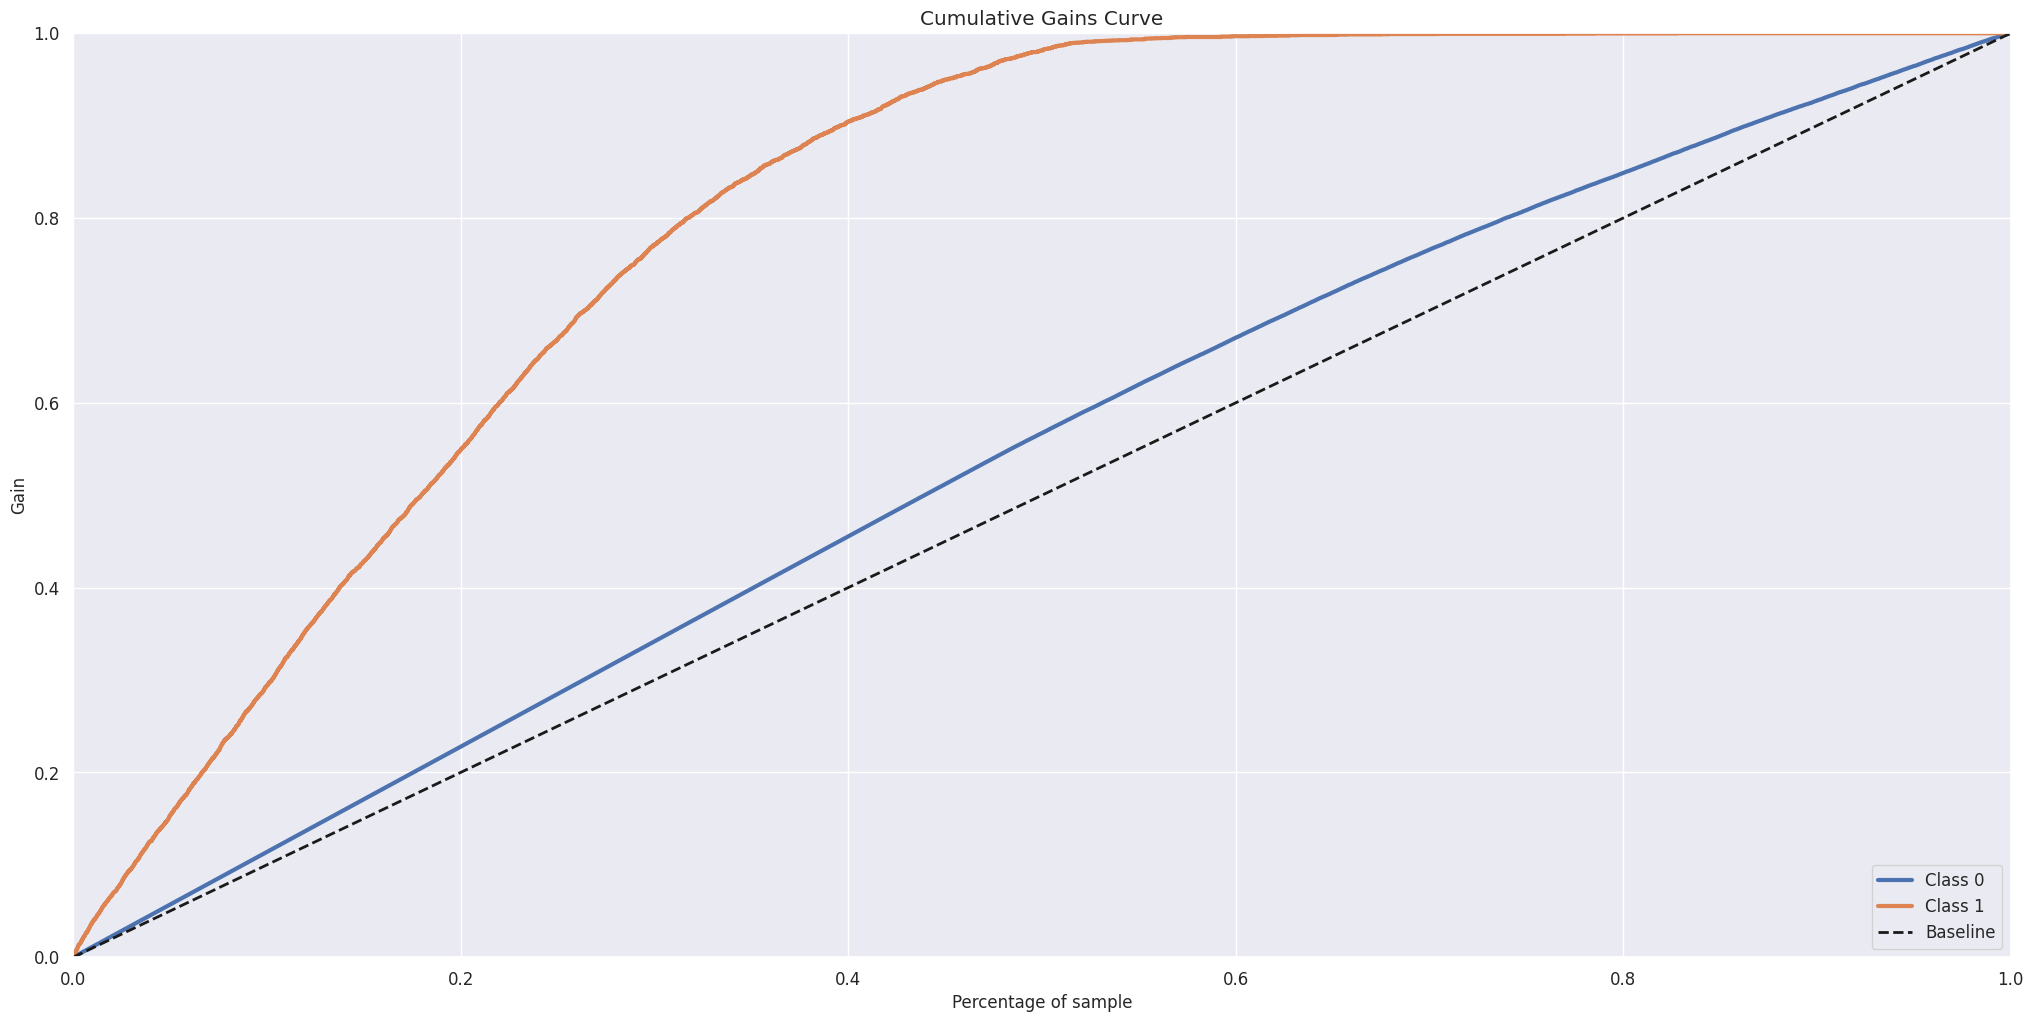

In [80]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain( y_test, yhat );

## 9.2. Lift Curve

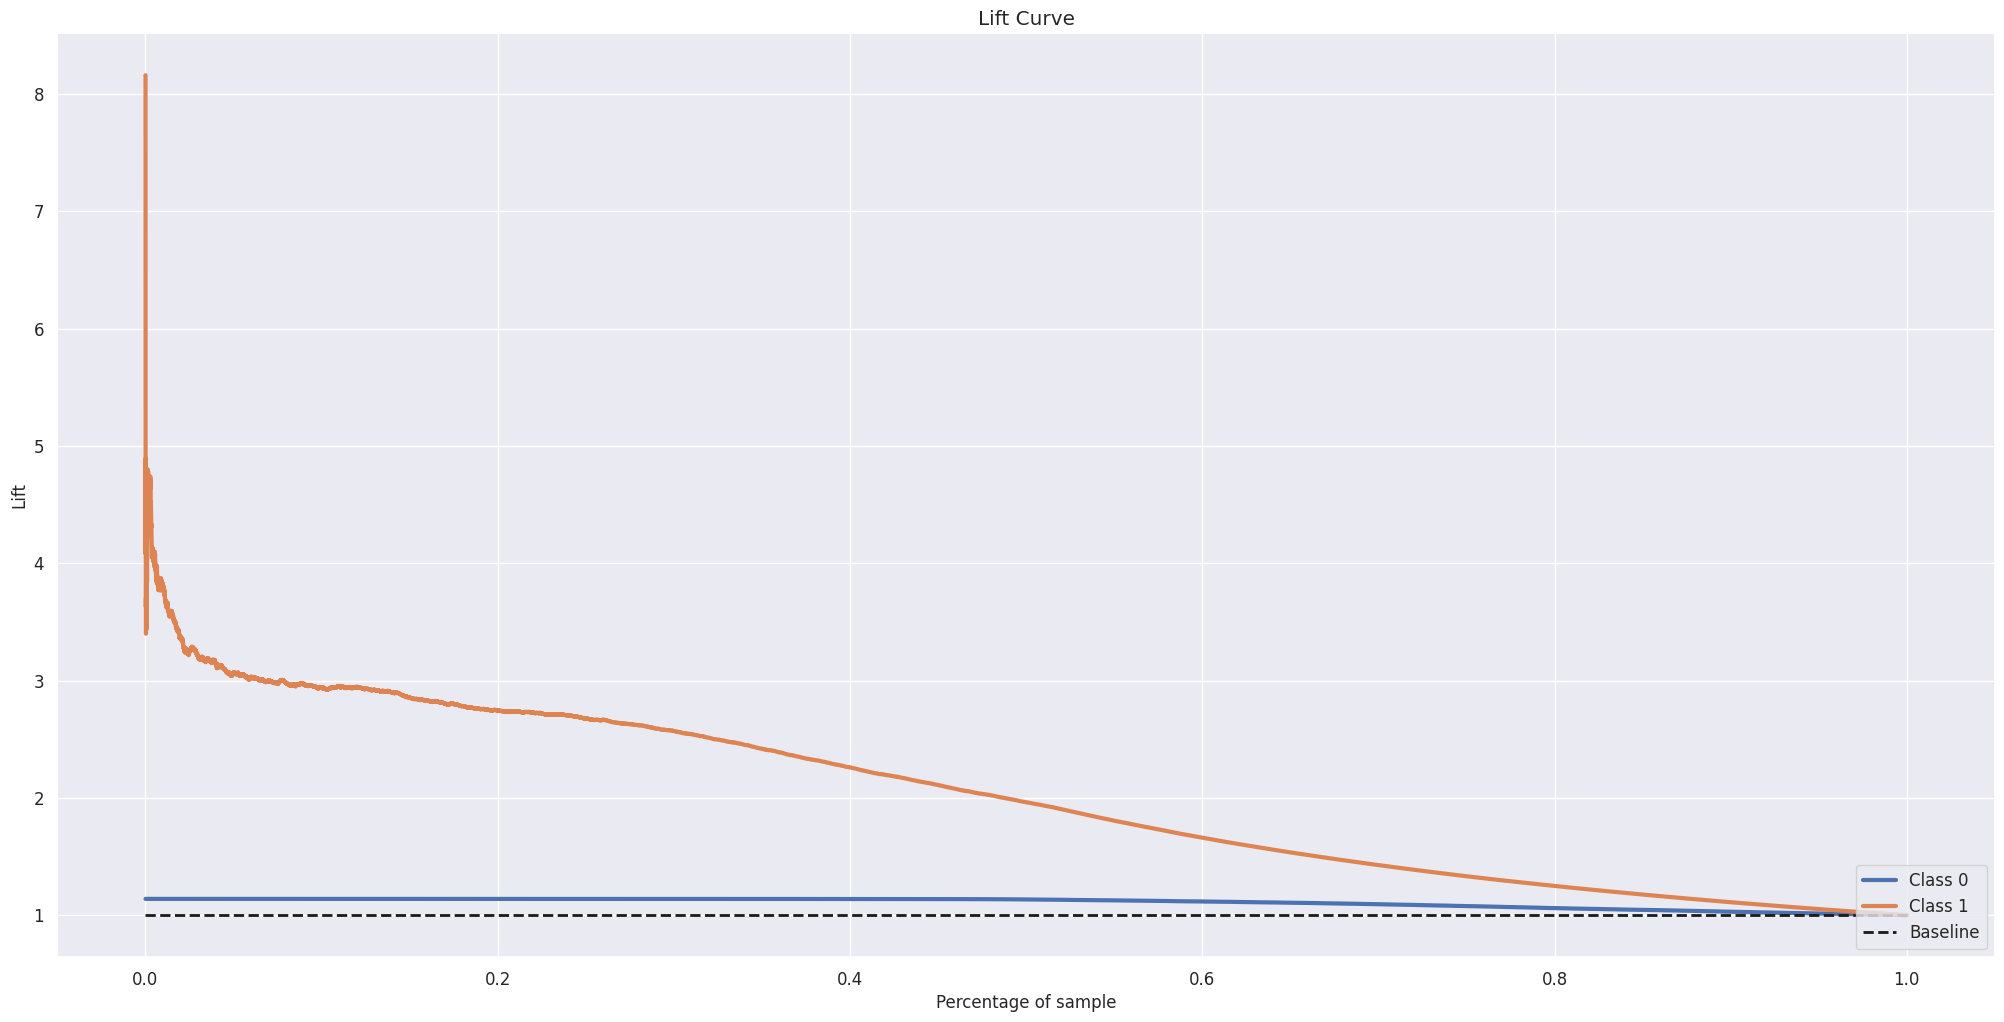

In [81]:
#Scikitplot library is there to help
skplt.metrics.plot_lift_curve( y_test, yhat );

## 9.3. Results

### 1 %

In [82]:
# performance
precisionk, data_precision = precision_at_k( df_final, 0.01 )
recallk, data_recall = recall_at_k(df_final, 0.01)

precisionk = np.round(precisionk , 2 ).astype( str )
recallk = np.round(recallk , 2 ).astype( str )

result_1 = pd.DataFrame([[1, precisionk, recallk]], columns=['Percentage', 'Precision at k', 'Recall at k'])
result_1

,Percentage,Precision at k,Recall at k
0,1,0.47,0.04


### 5 %

In [83]:
precisionk, data_precision = precision_at_k( df_final, 0.05 )
recallk, data_recall = recall_at_k(df_final, 0.05)

precisionk = np.round(precisionk , 2 ).astype( str )
recallk = np.round(recallk , 2 ).astype( str )

result_5 = pd.DataFrame([[5, precisionk, recallk]], columns=['Percentage', 'Precision at k', 'Recall at k'])
result_5

,Percentage,Precision at k,Recall at k
0,5,0.38,0.15


### 10% 

In [84]:
precisionk, data_precision = precision_at_k( df_final, 0.10 )
recallk, data_recall = recall_at_k(df_final, 0.10)

precisionk = np.round(precisionk , 2 ).astype( str )
recallk = np.round(recallk , 2 ).astype( str )

result_10 = pd.DataFrame([[10, precisionk, recallk]], columns=['Percentage', 'Precision at k', 'Recall at k'])
result_10

,Percentage,Precision at k,Recall at k
0,10,0.36,0.29


### 20%

In [85]:
precisionk, data_precision = precision_at_k( df_final, 0.20 )
recallk, data_recall = recall_at_k(df_final, 0.20)

precisionk = np.round(precisionk , 2 ).astype( str )
recallk = np.round(recallk , 2 ).astype( str )

result_20 = pd.DataFrame([[20, precisionk, recallk]], columns=['Percentage', 'Precision at k', 'Recall at k'])
result_20

,Percentage,Precision at k,Recall at k
0,20,0.34,0.55


### 33%

In [86]:
precisionk, data_precision = precision_at_k( df_final, 0.33 )
recallk, data_recall = recall_at_k(df_final, 0.33)

precisionk = np.round(precisionk , 2 ).astype( str )
recallk = np.round(recallk , 2 ).astype( str )

result_33 = pd.DataFrame([[33, precisionk, recallk]], columns=['Percentage', 'Precision at k', 'Recall at k'])
result_33

,Percentage,Precision at k,Recall at k
0,33,0.3,0.82


### 50%

In [87]:
precisionk, data_precision = precision_at_k( df_final, 0.50 )
recallk, data_recall = recall_at_k(df_final, 0.50)

precisionk = np.round(precisionk , 2 ).astype( str )
recallk = np.round(recallk , 2 ).astype( str )

result_50 = pd.DataFrame([[50, precisionk, recallk]], columns=['Percentage', 'Precision at k', 'Recall at k'])
result_50

,Percentage,Precision at k,Recall at k
0,50,0.24,0.98


### 9.3.1. Summary

In [88]:
list_results = pd.concat([result_1, result_5, result_10, result_20, result_33, result_50])
list_results

,Percentage,Precision at k,Recall at k
0,1,0.47,0.04
0,5,0.38,0.15
0,10,0.36,0.29
0,20,0.34,0.55
0,33,0.3,0.82
0,50,0.24,0.98


- Para alcançar 29% dos interessados em um novo seguro automotivo, é necessário contactar 10% dos clientes atuais
- Para alcançar 55% dos interessados em um novo seguro automotivo, é necessário contactar 20% dos clientes atuais
- Para alcançar 82% dos interessados em um novo seguro automotivo, é necessário contactar 33% dos clientes atuais
- Para alcançar 98% dos interessados em um novo seguro automotivo, é necessário contactar 50% dos clientes atuais

# 10.0. Deploy to Production

In [89]:
# Save trained model
pickle.dump( model_xgb_tuned, open('../src/models/model_xgboost.pkl', 'wb') )

## 10.1. Health Insurance Class

In [71]:
import pickle
import pandas as pd

class HealthInsurance:
    def __init__( self ):
        self.home_path = ''
        self.annual_premium_scaler = pickle.load( open( self.home_path + 'features/annual_premium_scaler.pkl', 'rb') )
        self.age_scaler = pickle.load( open( self.home_path + 'features/age_scaler.pkl', 'rb') )
        self.vintage_scaler = pickle.load( open( self.home_path + 'features/vintage_scaler.pkl', 'rb') )
        self.target_encode_gender_scaler = pickle.load( open( self.home_path + 'features/target_encode_gender_scaler.pkl', 'rb') )
        self.target_encode_region_code_scaler = pickle.load( open( self.home_path + 'features/target_encode_region_code_scaler.pkl', 'rb') )
        self.fe_policy_sales_channel_scaler = pickle.load( open( self.home_path + 'features/fe_policy_sales_channel_scaler.pkl','rb') )

    def data_cleaning( self, df1 ):
        # Rename Columns
        cols_new = ['id', 'gender', 'age', 'driving_license', 'region_code',
       'previously_insured', 'vehicle_age', 'vehicle_damage', 'annual_premium',
       'policy_sales_channel', 'vintage', 'response']

        df1.columns = cols_new

        return df1


    def feature_engeneering( self, df2 ):
        # vehicle age
        df2['vehicle_age'] = df2['vehicle_age'].apply( lambda x: 'over_2_years' if x == '> 2 Years' else
                                                                 'between_1_2_year' if x == '1-2 Year' else
                                                                 'below_1_year')
        
        # vehicle damage
        df2['vehicle_damage'] = df2['vehicle_damage'].apply( lambda x: 1 if x == 'Yes' else 0 )

        return df2

    
    def data_preparation( self, df5 ):

        #annual_premium
        df5['annual_premium'] = self.annual_premium_scaler.transform( df5[['annual_premium']].values )
       
        # age
        df5['age'] = self.age_scaler.transform( df5[['age']].values )
     
        # vintage
        df5['vintage'] = self.vintage_scaler.transform( df5[['vintage']].values )
    
        # gender - Target Enconding
        df5.loc[:, 'gender'] = df5.loc[:, 'gender'].map( self.target_encode_gender_scaler)
                
        # region_code -  Frequency Encoding / Target Encoding  / Weighted Target Encoding
        df5.loc[:, 'region_code'] = df5['region_code'].map( self.target_encode_region_code_scaler )
                
        # vehicle_age - One Hot Enconding / Order Encoding
        df5 = pd.get_dummies(df5, prefix='vehicle_age', columns=['vehicle_age'] )
        
        # policy_sales_channel  - Target Encoding / Frequency Ecoding
        df5.loc[:, 'policy_sales_channel'] = df5['policy_sales_channel'].map( self.fe_policy_sales_channel_scaler )


        # fillna
        df5 = df5.fillna( 0 )


        # Feature Selected
        cols_selected = ['annual_premium', 'vintage', 'age', 'region_code', 'vehicle_damage', 'previously_insured',
                 'policy_sales_channel']

        return df5[ cols_selected ]


    def get_prediction( self, model, original_data, test_data):
        #model prediction
        pred = model.predict_proba( test_data )

        #join prediction into original data
        original_data['score'] = pred[:, 1].tolist()

        return original_data.to_json( orient='records', date_format='iso')
        

## 10.2. API Handler

In [72]:
import pickle
import pandas as pd
from flask import Flask, request, Response
from healthinsurance.HealthInsurance import HealthInsurance
import os

# loading model
path = ''
model = pickle.load( open( path + 'models/model_xgboost.pkl', 'rb') )

# Initialize API
app = Flask( __name__ )

@app.route('/predict', methods=['POST'] )
def health_insurance_predict():
    test_json = request.get_json()

    if test_json: # there is data
        if isinstance( test_json, dict ): #unique_example
            test_raw = pd.DataFrame( test_json, index=[0] )

        else: #multiple_example
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() )

        # Instantiate HealthInsurance Class:
        pipeline = HealthInsurance()

        # data cleaning
        df1 = pipeline.data_cleaning( test_raw )

        # feature engeneering
        df2 = pipeline.feature_engeneering( df1 )

        # data preparation
        df3 = pipeline.data_preparation( df2 )

        # prediction
        df_response = pipeline.get_prediction( model, test_raw, df3 )
            
        return df_response

    else: 
        return Response( '{}', status=200, mimetype='application/json' )

if __name__ == '__main__':
    port = os.environ.get('PORT', 5000)
    app.run( '0.0.0.0', port=port, debug=True )


ModuleNotFoundError: No module named 'healthinsurance'

## 10.3. API Tester

In [28]:
import requests

In [29]:
df_test = pd.read_csv('../data/raw/test.csv')

df_pred = df_test.sample(3)

In [30]:
data = json.dumps( df_pred.to_dict( orient='records' ) )

In [31]:
data

'[{"id": 477921, "Gender": "Female", "Age": 25, "Driving_License": 1, "Region_Code": 33.0, "Previously_Insured": 1, "Vehicle_Age": "< 1 Year", "Vehicle_Damage": "No", "Annual_Premium": 29119.0, "Policy_Sales_Channel": 152.0, "Vintage": 116}, {"id": 411950, "Gender": "Male", "Age": 25, "Driving_License": 1, "Region_Code": 50.0, "Previously_Insured": 1, "Vehicle_Age": "< 1 Year", "Vehicle_Damage": "No", "Annual_Premium": 26876.0, "Policy_Sales_Channel": 152.0, "Vintage": 206}, {"id": 497242, "Gender": "Male", "Age": 37, "Driving_License": 1, "Region_Code": 33.0, "Previously_Insured": 0, "Vehicle_Age": "1-2 Year", "Vehicle_Damage": "Yes", "Annual_Premium": 2630.0, "Policy_Sales_Channel": 124.0, "Vintage": 221}]'

In [32]:
# API Call
url = 'http://0.0.0.0:5000/predict'
#url = 'https://healthinsurance-app.onrender.com/predict'
header = {'Content-type': 'application/json'}

r = requests.post(url, data=data, headers=header )
print( 'Status Code {}'.format( r.status_code) )

Status Code 200


In [33]:
d1 = pd.DataFrame( r.json(), columns=r.json()[0].keys() )
#d1.head()
d1.sort_values( 'score', ascending=False ).head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,score
2,497242,0.138596,0.261538,1,0.102051,0,between_1_2_year,1,-1.620292,124.0,0.730104,0.251305
0,477921,0.104581,0.076923,1,0.102051,1,below_1_year,0,-0.083655,152.0,0.366782,0.001863
1,411950,0.138596,0.076923,1,0.061799,1,below_1_year,0,-0.213772,152.0,0.678201,0.001058
